In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

In [2]:
############################
######## LIBRAIRIES ########
############################
print('Importing Librairies...')
import pyttsx3
engine = pyttsx3.init()

engine.say("Importing the librairies")
engine.runAndWait()

import pandas as pd

from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os
import datetime as dt
import numpy as np

import shelve
import ppscore as pps

import Stationarity
import Base

print('Librairies imported\n')
%matplotlib inline
plt.style.use('seaborn')
engine.say("librairie imported")
engine.runAndWait()

import warnings
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame.")
warnings.filterwarnings("ignore", message="Try using .loc[row_indexer,col_indexer] = value instead")
warnings.filterwarnings("ignore", message="The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.")
warnings.filterwarnings("ignore", message="The inverse of the variance-covariance matrix ")
print('Prêt')

Importing Librairies...
Librairies imported

Prêt


In [3]:
%%time
engine.say("Loading the teeckers")
engine.runAndWait()

SECTOR = []
TICKERS = []
BLACKLIST = ['BRK.B','BF.B']
df_constituents = pd.read_csv('constituents.csv')
df_constituents = df_constituents.drop_duplicates(['Symbol'])
try:
    df_constituents = df_constituents.drop(['Unnamed: 0'],axis=1)
except:
    pass
SECTOR = list(sorted(set(df_constituents.Sector)))        
TICKERS = list(sorted(set(df_constituents.Symbol.to_list())))
for x in BLACKLIST:
    TICKERS.remove(x)

engine.say("Teeckers loaded")
engine.runAndWait()

CPU times: user 12.2 ms, sys: 4.18 ms, total: 16.4 ms
Wall time: 6.02 s


In [4]:
%%time
df_daily = pd.read_csv('BASE_DAILY/A.csv')
try:
    df_daily = df_daily.drop(['Unnamed: 0'],axis=1)
except:
    pass
df_hourly = pd.read_csv('BASE_HOURLY/A.csv')
try:
    df_hourly = df_hourly.drop(['Unnamed: 0'],axis=1)
except:
    pass

CPU times: user 19.3 ms, sys: 5.64 ms, total: 24.9 ms
Wall time: 26.7 ms


In [5]:
%%time
if df_daily.Date[0] <= df_hourly.Date[0]:
    df_daily = df_daily[df_daily.Date >= df_hourly.Date[0][:10]].reset_index(drop=True)

if df_daily.Date[0] >= df_hourly.Date[0]:
    df_hourly = df_hourly[df_hourly.Date >= df_daily.Date[0]].reset_index(drop=True)


CPU times: user 3.65 ms, sys: 1.51 ms, total: 5.15 ms
Wall time: 4.57 ms


In [6]:
df_daily.head()

,Date,Open,High,Low,Close,Volume
0,2015-08-27,36.745,36.745,35.870,36.655,-1
1,2015-08-28,36.415,36.670,36.150,36.495,-1
2,2015-08-31,36.870,37.140,35.485,36.305,-1
3,2015-09-01,35.465,35.590,34.565,34.750,-1
4,2015-09-02,35.410,35.535,34.885,35.525,-1


In [7]:
df_daily.tail()

,Date,Open,High,Low,Close,Volume
1249,2020-08-13,97.510,99.120,97.020,98.780,-1
1250,2020-08-14,98.475,98.705,96.885,97.350,-1
1251,2020-08-17,97.225,98.695,97.090,97.510,-1
1252,2020-08-18,98.065,98.730,96.965,97.825,-1
1253,2020-08-19,95.055,99.395,94.755,97.975,-1


In [8]:
%%time
df_gap = pd.DataFrame()
df_gap['Gap'] = (df_daily.Open - df_daily.Close.shift(1)) * 100 / df_daily.Open
df_gap.index = df_daily.Date 
df_gap = df_gap.dropna()
for x in range(len(df_gap)):
    globals()['G%s' %x] = []
df_gap.head()

CPU times: user 8.05 ms, sys: 2.83 ms, total: 10.9 ms
Wall time: 10.3 ms


,Gap
Date,
2015-08-28,-0.659069
2015-08-31,1.017087
2015-09-01,-2.368532
2015-09-02,1.863880
2015-09-03,1.264591


In [9]:
df_gap.tail()

,Gap
Date,
2020-08-13,-0.117937
2020-08-14,-0.309723
2020-08-17,-0.128568
2020-08-18,0.565951
2020-08-19,-2.914102


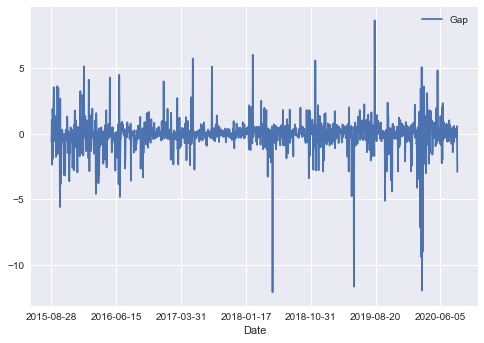

In [10]:
df_gap.plot()

In [11]:
df_gap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 2015-08-28 to 2020-08-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gap     1253 non-null   float64
dtypes: float64(1)
memory usage: 19.6+ KB


In [12]:
df_gap.describe()

,Gap
count,1253.000000
mean,-0.064827
std,1.352147
min,-12.073151
25%,-0.365497
50%,0.038895
75%,0.391362
max,8.619608


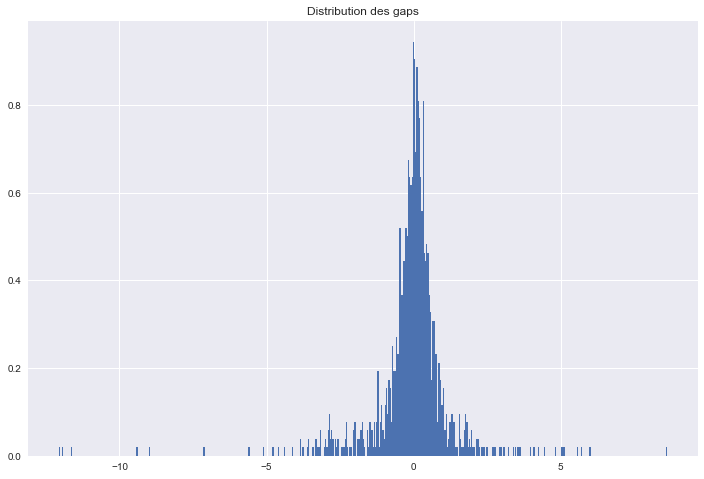

CPU times: user 1.66 s, sys: 14.3 ms, total: 1.68 s
Wall time: 1.69 s


In [13]:
%%time
import scipy
import scipy.stats

data = df_gap.Gap.values

bins = df_gap.shape[0]

dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'alpha', 'chi', 'chi2']

y, x = np.histogram(data, bins=bins, density=True)
# Milieu de chaque classe
x = (x + np.roll(x, -1))[:-1] / 2.0

plt.figure(figsize=(12,8))
plt.hist(data, bins=500, density=True)
plt.title("Distribution des gaps")
plt.show()

In [14]:
%%time
sse = np.inf
sse_thr = 0.10

# Pour chaque distribution
for name in dist_names:

	# Modéliser
	dist = getattr(scipy.stats, name)
	param = dist.fit(data)

	# Paramètres
	loc = param[-2]
	scale = param[-1]
	arg = param[:-2]

	# PDF
	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
	# SSE
	model_sse = np.sum((y - pdf)**2)

	# Si le SSE est ddiminué, enregistrer la loi
	if model_sse < sse :
		best_pdf = pdf
		sse = model_sse
		best_loc = loc
		best_scale = scale
		best_arg = arg
		best_name = name

	# Si en dessous du seuil, quitter la boucle
	if model_sse < sse_thr :
		break

CPU times: user 785 ms, sys: 3.95 ms, total: 789 ms
Wall time: 790 ms


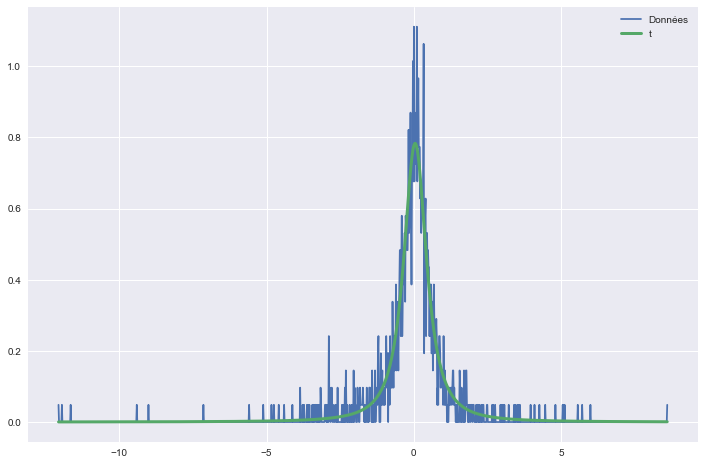

Selected Model :  t
Loc. param. :  0.04785163734369269
Scale param. :  0.4344557607997196
Other arguments :  (1.4902083665409565,)
SSE :  2.3290540103435884
CPU times: user 295 ms, sys: 7.58 ms, total: 302 ms
Wall time: 302 ms


In [15]:
%%time
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Données")
plt.plot(x, best_pdf, label=best_name, linewidth=3)
plt.legend(loc='upper right')
plt.show()

# Détails sur la loi sélectionnée
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)

In [16]:
i = 0
df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])]

,Date,Open,High,Low,Close,Volume
0,2015-08-27 15:30:00,36.745,36.745,35.915,36.020,-1
1,2015-08-27 16:00:00,36.020,36.330,35.975,36.300,-1
2,2015-08-27 17:00:00,36.300,36.370,36.145,36.265,-1
3,2015-08-27 18:00:00,36.265,36.545,36.265,36.545,-1
4,2015-08-27 19:00:00,36.545,36.610,36.395,36.545,-1
5,2015-08-27 20:00:00,36.545,36.550,36.015,36.040,-1
6,2015-08-27 21:00:00,36.040,36.655,35.870,36.655,-1


In [17]:
df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])].High[i]

36.745

In [18]:
df_gap.shape, df_daily.shape, df_hourly.shape

((1253, 1), (1254, 6), (8766, 6))

In [19]:
df_gap.head()

,Gap
Date,
2015-08-28,-0.659069
2015-08-31,1.017087
2015-09-01,-2.368532
2015-09-02,1.863880
2015-09-03,1.264591


In [20]:
%%time
for i in range(len(df_daily)):
    for x in range(len(df_gap)):
        if df_gap.Gap[i] > 0:
            globals()['G%s' %x].append((df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])].reset_index(drop=True).High[0] - \
                df_daily.Close.shift(1)[i+1]) * 100 / df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])].reset_index(drop=True).High[0])
        
        if df_gap.Gap[i] < 0:
            globals()['G%s' %x].append((df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])].reset_index(drop=True).Low[0] - \
                df_daily.Close.shift(1)[i+1]) * 100 / df_hourly[(df_hourly.Date >=df_daily.Date[i])&(df_hourly.Date <df_daily.Date[i+1])].reset_index(drop=True).High[0])
        


IndexError: index out of bounds

In [28]:
df_gap['G1'] = G1
df_gap['G2'] = G2
df_gap['G3'] = G3
df_gap['G4'] = G4
df_gap['G5'] = G5
df_gap['G6'] = G6

In [29]:
df_gap

,Gap,G1,G2,G3,G4,G5,G6
Date,,,,,,,
2015-08-28,-0.659069,-2.013879,-2.013879,-2.013879,-2.013879,-2.013879,-2.013879
2015-08-31,1.017087,0.477229,0.477229,0.477229,0.477229,0.477229,0.477229
2015-09-01,-2.368532,-2.207862,-2.207862,-2.207862,-2.207862,-2.207862,-2.207862
2015-09-02,1.863880,2.360214,2.360214,2.360214,2.360214,2.360214,2.360214
2015-09-03,1.264591,-0.282287,-0.282287,-0.282287,-0.282287,-0.282287,-0.282287
...,...,...,...,...,...,...,...
2020-07-31,0.088523,-1.192679,-1.192679,-1.192679,-1.192679,-1.192679,-1.192679
2020-08-03,0.526588,-1.796193,-1.796193,-1.796193,-1.796193,-1.796193,-1.796193
2020-08-04,-0.660401,0.582544,0.582544,0.582544,0.582544,0.582544,0.582544


In [7]:
engine.say("Ignition du Lumberjack")
engine.runAndWait() 

##############################################
######## INITIALISATION DES VARIABLES ########
##############################################

number = 10000 # Nombre de periodes pour l'historique
diloug = 120 # 6 mois pour le training
nb_pattes = 2
coef_lim = 4

break_it = 0
stop = 0
full_stop = 1

sens = 'INIT'
name = 'INIT'

_os = 0
ol = 0
cs = 0
cl = 0
buy1 = 0
buy2 = 0
buy3 = 0
sell1 = 0
sell2 = 0
sell3 = 0
nbposs = 0
nbposl = 0
nbpos = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnll = 0
pnls = 0
dyn_net_pnl = 0
amplitude = 0
cste = 0
mise = 0
mise0 = 0
mise1 = 0
mise2 = 0
mise3 = 0
mise4 = 0
mark = -1
lim_s1 = 2
lim_s2 = 2.8
lim_s3 = 3.3
lim_l1 = -2
lim_l2 = -2.8
lim_l3 = -3.4
lim_cs = -0.13
lim_cl = 0.13
dyn_S = 0
dynf = 0
_mean = 0
_std = 0
big_len = 0
chi_square_value = 0
p_value = 0
ev = 0
v = 0
jh_results = 0
v1 = 0
v2 = 0
skew = 0
kurtosis = 0
full_stop = 0
residu = 0

p0os = 0
p1os = 0
p2os = 0
p3os = 0
p4os = 0

deviamax = 0
take_profit = 50 
usable_margin = 999.99


debut = dt.date(1,1,1)
fin = dt.date(1,1,1)
split = dt.date(1,1,1)


base_pair0 = pd.DataFrame()
base_pair1 = pd.DataFrame()
base_pair2 = pd.DataFrame()
base_pair3 = pd.DataFrame()
base_pair4 = pd.DataFrame()
pair = pd.DataFrame()
pair0 = pd.DataFrame()
pair1 = pd.DataFrame()
pair2 = pd.DataFrame()
pair3 = pd.DataFrame()
pair4 = pd.DataFrame()
daf = pd.DataFrame()
dynamic_combo = pd.DataFrame()
dynamic_residu = pd.DataFrame()
combo = pd.DataFrame()

coef = []
S = []
PAIR = []
CSTE = []
DYNS = []
TICKERS = []
BIG_TICKERS = []
TIME_FRAME = []
INDEX = []
INSTRUMENTS = []
PACK = []
SL_PACK = []
SHORT_LIST = []
OPEN_POZ = []


D = {}
D = {'_os':_os, 'ol':ol, 'cs':cs, 'cl':cl, 'buy1':buy1, 'buy2':buy2, 'buy3':buy3, 'sell1':sell1, 'sell2':sell2, 'sell3':sell3, 'nbposs':nbposs, 'nbposl':nbposl, 'nbpos':nbpos, 'nbre_trade':nbre_trade, 'nbre_trade_long':nbre_trade_long, 'nbre_trade_short':nbre_trade_short, 'pnll':pnll, 'pnls':pnls, 'amplitude':amplitude, 'cste':cste, 'mise':mise, 'mise0':mise0, 'mise1':mise1, 'mise2':mise2, 'mise3':mise3, 'mise4':mise4, 'mark':mark, 'lim_s1':lim_s1, 'lim_s2':lim_s2, 'lim_s3':lim_s3, 'lim_l1':lim_l1, 'lim_l2':lim_l2, 'lim_l3':lim_l3, 'lim_cs':lim_cs, 'lim_cl':lim_cl, 'dyn_S':dyn_S, '_mean':_mean, '_std':_std, 'big_len':big_len, 'chi_square_value':chi_square_value, 'p_value':p_value, 'ev':ev, 'v':v, 'jh_results':jh_results, 'v1':v1, 'v2':v2, 'skew':skew, 'kurtosis':kurtosis, 'dynf':dynf, 'residu':residu, 'p0os':p0os, 'p1os':p1os, 'p2os':p2os, 'p3os':p3os, 'p4os':p4os, 'debut':debut, 'fin':fin, 'split':split, 'base_pair0':base_pair0, 'base_pair1':base_pair1, 'base_pair2':base_pair2, 'base_pair3':base_pair3, 'base_pair4':base_pair4, 'pair':pair, 'pair0':pair0, 'pair1':pair1, 'pair2':pair2, 'pair3':pair3, 'pair4':pair4, 'coef':coef, 'S':S, 'PAIR':PAIR, 'CSTE':CSTE, 'DYNS':DYNS, 'TICKERS':TICKERS, 'BIG_TICKERS':BIG_TICKERS, 'TIME_FRAME':TIME_FRAME, 'INDEX':INDEX, 'INSTRUMENTS':INSTRUMENTS, 'PACK':PACK, 'SL_PACK':SL_PACK, 'SHORT_LIST':SHORT_LIST, 'number':number, 'diloug':diloug, 'break_it':break_it, 'stop':stop, 'full_stop':full_stop, 'sens':sens, 'name':name, 'dyn_net_pnl':dyn_net_pnl, 'deviamax':deviamax,'take_profit':take_profit,'nb_pattes':nb_pattes,'OPEN_POZ':OPEN_POZ}

for key,val in D.items():
    exec(key + '=val')
engine.say("בסדר")
engine.runAndWait()


print(Style.BRIGHT,Back.LIGHTWHITE_EX,Fore.RED,'Longueur de D',len(D),Style.RESET_ALL)
type(D)

   Longueur de D 94 


dict

In [14]:
engine.say("I've got the big class, intercosmik")
engine.runAndWait()

###########################
######### CLASSES #########
###########################

class IBapi(EWrapper, EClient):
    def __init__(self):
	    EClient.__init__(self, self)
	    self.data = [] #Initialize variable to store candle
    
    def tickPrice(self, reqId, tickType, price, attrib):
	    if tickType == 2 and reqId == 1:
		    print('The current ask price is: ', price)
    
    def nextValidId(self, orderId: int):
	    super().nextValidId(orderId)
	    self.nextorderId = orderId
	    print('The next valid order id is: ', self.nextorderId)

    def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
	    print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
	
    def openOrder(self, orderId, contract, order, orderState):
	    print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)

    def execDetails(self, reqId, contract, execution):
	    print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)
    
    def error(self, reqId, errorCode, errorString):
        if errorCode == 202:
            print('order canceled')

engine.say("nu")
engine.runAndWait()

In [17]:
engine.say("I know what is my function")
engine.runAndWait()

############################
######## FONCTIONS ########
###########################

def run_loop():
    app.run()

#Function to create FX Order contract
def FX_order(symbol):
    contract = Contract()
    contract.symbol = symbol[:3]
    contract.secType = 'CASH'
    contract.exchange = 'IDEALPRO'
    contract.currency = symbol[3:]
    return contract

def Stock_contract(symbol, secType='STK', exchange='SMART', currency='USD'):
	''' custom function to create stock contract '''
	contract = Contract()
	contract.symbol = symbol
	contract.secType = secType
	contract.exchange = exchange
	contract.currency = currency
	return contract

def contractDetails(self, reqId: int, contractDetails):
	    self.contract_details[reqId] = contractDetails

def get_contract_details(self, reqId, contract):
    self.contract_details[reqId] = None
    self.reqContractDetails(reqId, contract)
    #Error checking loop - breaks from loop once contract details are obtained
    for err_check in range(50):
        if not self.contract_details[reqId]:
            time.sleep(0.1)
        else:
            break
    #Raise if error checking loop count maxed out (contract details not obtained)
    if err_check == 49:
        raise Exception('error getting contract details')
    #Return contract details otherwise
    return app.contract_details[reqId].contract 


app = IBapi()


#async def acsummcoro(ib):
 #   df_ac = util.df(ib.accountSummary())
  #  NLV = float(df_ac[df_ac.tag.isin(['NetLiquidation'])].reset_index(drop=0).value[0])
   # maintMargin = float(df_ac[df_ac.tag.isin(['InitMarginReq'])].reset_index(drop=0).value[0])
    #unrealPnL = float(df_ac[df_ac.tag.isin(['UnrealizedPnL'])].reset_index(drop=0).value[0])
    #realPnL = float(df_ac[df_ac.tag.isin(['RealizedPnL'])].reset_index(drop=0).value[0])
    #acsum = {"NLV": NLV, "margin": maintMargin, "unreaPnL": unrealPnL, "realPnL": realPnL}
    #await ib.updateEvent
    #return (acsum)

def remove_index(INDEX): 
    for key,val in D.items():
        exec(key + '=val')
    for x in range(big_len):
        for ind in INDEX:
            if ind not in (globals()['uni_df%s' % x]).index :
                INDEX.remove(ind)
    return(INDEX)

def clean_index(df):
    for key,val in D.items():
        exec(key + '=val')
    I = []
    for i in range(0,len(df)):
        if df.index[i] not in INDEX:
            I.append(i)
    df = df.drop(df.index[I])
    return(df)

def isname(pair,D):
    for key,val in D.items():
        exec(key + '=val')
    for x in range(nb_pattes):
        if pair.equals(globals()['pair%s' % x]):
            name = TICKERS[x]  
    return(name,D)

def revname(name,D):
    for key,val in D.items():
        exec(key + '=val')
    for x in range(nb_pattes):
        if name == TICKERS[x]:
            pair = globals()['pair%s' % x]
    return(pair,D)

def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()
    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    if p_value <= 0.05:
        stop = 0
    else:
        stop = 1
    return(stop)

def skewness(df):
    if skew < -0.1 or skew > 0.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def kurtos(df):
    if kurtosis > -3.1 or kurtosis < 3.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor(df):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor_diff(diff):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        p = 1
    else:
        stop = 1
    return()

def test_stationarity(timeseries,lag):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

def test_adf(df):
    X = df['Close'].values
    result_adf = adfuller(X)
    
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        stop = 1
    else:
        stop = 0
        
    X = diff[1:].values
    result_adf = adfuller(X)
    
    if result_adf[1] >= 0.05 :
        stop = 1

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        stop = 1

    else:
        stop = 0
    return(stop)
def train(base_pair0,base_pair1,base_pair2,base_pair3,base_pair4,TIME_FRAME,TICKERS,D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, deviamax, password, pair2, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,take_profit,usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2,OPEN_POZ

    for key,val in D.items():
        exec(key + '=val')
    
    now = time.localtime(time.time())
    print('\nHeure locale du début du train : ',time.strftime("%Y-%m-%d %H:%M:%S", now),'\n')

    
    print(Style.RESET_ALL,'')
    debut = TIME_FRAME[-diloug]
    split = TIME_FRAME[-1]
    fin = TIME_FRAME[-1]
    print(Fore.MAGENTA,'')
    print('|||| TIME_FRAME <---> debut :',TIME_FRAME[-diloug],' <---> split : ',split) 
    print(Style.RESET_ALL)
    D['debut'] = debut
    D['split'] = split
    D['fin'] = fin
    for key,val in D.items():
        exec(key + '=val')
    
    PAIR = []
    for x in range(nb_pattes):
        globals()['pair%s' % x] = globals()['base_pair%s' % x][(globals()['base_pair%s' % x].index >= debut)&(globals()['base_pair%s' % x].index <= split)]
        globals()['pair%s' % x]['Local time'] = globals()['pair%s' % x].index
        globals()['pair%s' % x].reset_index(drop=True, inplace=True)
        D['pair%s' % x] = globals()['pair%s' % x]
        print('Récupération pair%s => ' % x,globals()['pair%s' % x].shape)
        PAIR.append(globals()['pair%s' % x])
    
    D['PAIR'] = PAIR
    
    for key,val in D.items():
        exec(key + '=val')
    print('Longueur de PAIR (liste des pair)', len(PAIR))

    for pair in PAIR:
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        print('Passage pour',name)
        model = sm.OLS(pair['Close'],pair.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()

        jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

        jarque_berra(pair)
        skewness(pair)
        kurtos(pair)
        autocor(pair)

    ####################
    daf = pd.DataFrame()
    ####################

    for pair in PAIR:
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        daf[name] = list(pair['Close'])
    daf.corr().style.background_gradient(cmap='coolwarm')
    
    D['daf'] = daf
    for key,val in D.items():
        exec(key + '=val')
    
    INTEGRE = []
    for col in range(1,len(daf.corr())):
        for ind in range(col):
            if daf.corr().iloc[ind,col] > 0.5 and daf.corr().iloc[ind,col] != 1:
                INTEGRE.append((daf.corr().index[ind],daf.corr().columns[col]))

    INTEGRE  = list(set(INTEGRE))
    D['INTEGRE'] = INTEGRE
    for key,val in D.items():
        exec(key + '=val')
    kmo_all,kmo_model=calculate_kmo(daf)

    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        if kmo_all[loop] >= 0.6:
            print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquat',Style.RESET_ALL)
        else:
            print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)
            break_it = 1

    chi_square_value,p_value=calculate_bartlett_sphericity(daf)
    if p_value < 0.05:
        stop = 0
    else:
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            #continue
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 434\n\n\n',Style.RESET_ALL)

    fa = FactorAnalyzer(rotation=None)
    fa.fit(daf)

    ev, v = fa.get_eigenvalues()

    PRINCIPAL_COMPOSANT = []
    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        if ev[loop] >= 1:
            PRINCIPAL_COMPOSANT.append((name,ev[loop]))

    jh_results = johasen(daf,0,1)
    v1 = jh_results.evec[:, 0]
    v2 = jh_results.evec[:, 1]
    if jh_results.eig[0] <= 0.05:
        stop = 0
    else:
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            #continue
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 456\n\n\n',Style.RESET_ALL)
    
    X = daf.iloc[:,1:]
    y = daf.iloc[:,0]
    reg = LinearRegression().fit(X, y)
    score = reg.score(X, y) *100
    coef = reg.coef_
    cste = reg.intercept_
    CSTE.append(cste)

    D['coef'] = coef
    D['cste'] = cste
    D['CSTE'] = CSTE
    for key,val in D.items():
        exec(key + '=val')
    
    if score > 70:
        print('SCORE > 70')
        stop = 0
        for loop,pair in enumerate (PAIR):
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if loop == 0:
                #continue
                print('Paire principale :',name)
            #loop += 1
            else:
                try:
                    print(name,' - coef : ',coef[loop-1]) 
                except:
                    print('Problème calculationique')
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 481\n\n\n',Style.RESET_ALL)
                           
    elif score > 50:
        print('SCORE > 50')
        loop = 0
        for pair in PAIR:
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if name == TICKERS[0]:
                continue
            loop += 1
            try:
                print(name,' : ',coef[loop])
            except:
                stop = 1
                if nbposs == 0 and nbposl == 0 : 
                    continue
                    print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 497\n\n\n',Style.RESET_ALL)

    else:
        print('SCORE < 50')
        stop = 1
        loop = 0
        for pair in PAIR:
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if name == TICKERS[0]:
                continue
            loop += 1
            try:
                print(name,' : ',coef[loop])
            except:
                stop = 1
                if nbposs == 0 and nbposl == 0 : 
                    print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 512\n\n\n',Style.RESET_ALL)
                    continue

    if nb_pattes == 2:
        combo = coef[0] * daf[TICKERS[1]] + cste
    elif nb_pattes == 3:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + cste
    elif nb_pattes == 4:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + coef[2] * daf[TICKERS[3]] + cste
    elif nb_pattes == 5:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + coef[2] * daf[TICKERS[3]] + coef[3] * daf[TICKERS[4]] + cste
    
    print('TICKERS : ',TICKERS)
    print('COEF',coef)
    print('CSTE',cste)
    print('Dernière valeur du combo à ',combo.iloc[-1])
    ########
    ### RESIDUS
    ########
    residu = daf[TICKERS[0]] - combo
    print('Derniere valeur du residu',residu.iloc[-1])
    S = (residu - residu.mean())/residu.std()
    print('Dernière valeur du Score',S.iloc[-1])
    _mean = residu.mean()
    print('Mean',_mean)
    _std = residu.std()
    print('Std',_std)

    D['_mean'] = _mean
    D['_std'] = _std
    D['S'] = S
    D['coef'] = coef
    D['residu'] = residu 
    D['combo'] = combo
    for key,val in D.items():
        exec(key + '=val')

    print(' Pour les TICKERS :',TICKERS,', - Moyenne du spread :',_mean,' - Std Dev du spread : ',_std)
    print('La déviation est de :',abs(S.iloc[-1])-S.mean())
    
    ####
    ## ANALYSE DES RESIDUS
    ###

    jarque_berra(residu)
    skewness(residu)
    kurtos(residu)
    residu_autocor = pd.DataFrame()
    residu_autocor['Close'] = residu.iloc[:]
    autocor(residu_autocor)

    model = sm.OLS(residu,residu.index)
    results = model.fit()
    residuals = results.resid
    summary = results.summary()
    name = 'Analyse des Résidus'
    jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

    dfoutput =  test_stationarity(residu,lag = 1)
    
    if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
        print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
        stop = 0
    
    else:
        print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 550\n\n\n',Style.RESET_ALL)

    #######
    ### RETOUR A LA MOYENNE
    #######
    dfoutput =  test_stationarity(residu,lag = 0)

    if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
        print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
        _retmoy1 = dfoutput[1]
        _retmoy6 = dfoutput[6]
        # stop = 0 # => On veut que tout soit validé avant. Donc pas de stop à 0 ici
    
    else:
        print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 565\n\n\n',Style.RESET_ALL)


    chi_square_value,p_value=calculate_bartlett_sphericity(daf)
    
    if p_value < 0.05:
        print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
    
    else:
        print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )

    fa = FactorAnalyzer(rotation=None)
    fa.fit(daf)

    ev, v = fa.get_eigenvalues()

    pca = PCA(n_components=2)
    pca.fit(daf)

    x_pca = pca.transform(daf)
    x_pca.shape


    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]

    jh_results = johasen(daf,0,1)

    v1 = jh_results.evec[:, 0]
    v2 = jh_results.evec[:, 1]

    if jh_results.eig[0] <= 0.05:
        print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
    
    else:
        print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)
    
    print('\nTEST DU FULL STOP - et stop à ',stop,' - ','\n')
    
    if stop == 0 and break_it != 1:
        print('\nFull Stop à 0\n')
        try:
            son = pygame.mixer.Sound("bsd.mp3")
            son.play()
            try:
                son = pygame.mixer.Sound("boul.mp3")
                son.play()
            except:
                pass
    
        except:
            engine.say("בסדר")
            engine.runAndWait()
            engine.say("בול! מצוין! הודו להשם כי טוב!")
            engine.runAndWait()
        full_stop = 0
        print('Trader, trader, pour information, la constante vaut ',cste)
        print(Back.LIGHTBLUE_EX,Fore.YELLOW,' P A C K     V A L I D E     = >      S L _ P A C K ',Style.RESET_ALL)
        try:
            amplitude = round(max(S),4) - round(min(S),4)
        except:
            amplitude = 0

        lim_s1 = amplitude/coef_lim * 1
        lim_s2 = amplitude/coef_lim * 2
        lim_s3 = amplitude/coef_lim * 3
        lim_l1 = -amplitude/coef_lim * 1
        lim_l2 = -amplitude/coef_lim * 2
        lim_l3 = -amplitude/coef_lim * 3

        _up1 = len([x for x in S.to_list() if x > lim_s1 and x < lim_s2])
        _up2 = len([x for x in S.to_list() if x > lim_s2 and x < lim_s3])
        _down1 = len([x for x in S.to_list() if x < lim_l1 and x > lim_l2])
        _down2 = len([x for x in S.to_list() if x < lim_l2 and x > lim_l3])

        if _down1 == 0:
            _down1 = 0.1
        if _down2 == 0:
            _down2 = 0.1
        if _up1 == 0:
            _up1 = 0.1
        if _up2 == 0:
            _up2 = 0.1

        _ratio1 = round((_up1/_down1) * 100,0) # 80 - 120
        _ratio2 = round((_up2/_down2) * 100,0) # 80 - 120
        _ratio_cross = round(((_up2+_down2)/(_up1+_down1) * 100),0) # > 50
        _freq1 = ((_up1+_down1)/len(S)) * 100
        _freq2 = ((_up2+_down2)/len(S)) * 100
        
        
        
        SL_PACK.append([TICKERS,_mean,_std,S,coef,residu,combo,daf,cste,lim_s1,lim_s2,lim_s3,lim_l1,lim_l2,lim_l3,_ratio1,_ratio2,_ratio_cross,\
        _freq1,_freq2,amplitude])
        print('\n\n')

        plt.ion() 
        plt.figure(figsize=(22,5)) 
        plt.plot(S,label='Score',c='dodgerblue')
        plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
        plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
        plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
        plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
        plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
        plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
        plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
        plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
        plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
        plt.legend(loc='upper left')
        plt.suptitle('COMBO : '+str(TICKERS)+' - RATIO1 : '+str(_ratio1)+' - RATIO2 : '+str(_ratio2)+' - RATIO_CROSS :'+str(_ratio_cross)+' - Freq1 : '+\
        str(_freq1)+' - Freq2 : '+str(_freq2)+' - dyn_S : '+str(list(S)[-1]))
        plt.title(' Nombre de pattes '+str(nb_pattes))
        plt.pause(0.05)
        
    else:
        print('\nFull Stop à 1\n')
        engine.say("לא טוב")
        engine.say("עוד פעם")
        engine.runAndWait()
        full_stop = 1
        break_it = 0
    
    for key,val in D.items():
        exec(key + '=val') 
    return(pair0,pair1,pair2,pair3,pair4,PAIR,split,S,SL_PACK,D)

def new_dyns(D):

    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,dynf0,dynf1,dynf2,dynf3,dynf4,mise1,mise2, mise3, mise4, mise0,take_profit,usable_margin, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2,OPEN_POZ

    for key,val in D.items():
        exec(key + '=val')

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    
    print('Rappel des TICKERS',TICKERS)
    print('Rappel des coef',coef)
    print('Rappel de cste',cste)
    
    print('Rappel du std',_std)
    print('Rappel du mean',_mean)

    for x in range(nb_pattes):
        globals()['mise%s' % x] = mise
        
    print('\n\nTAILLES DES POSITIONS (coef x mise en kilo devise):')
    print('Pour rappel les coef sont à ',coef)
    print('les tickers sont',TICKERS)
    print('la constante est cste',cste)

    print(TICKERS[0],', mise : ', mise0)
        
    for x in range(nb_pattes):
        if x == 0:
                continue
        print(TICKERS[x],', mise * coef : ', globals()['mise%s' % x] * (coef[x-1]))
            
    print('\n')
    
    for x in range(nb_pattes):
        try:
            if '/USD' in TICKERS[x]:
                globals()['dynf%s' % x] = ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            if 'USD/' in TICKERS[x]:
                globals()['dynf%s' % x] = 1 / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
        except:
            print(TICKERS[x],' => NON VALIDE')
    print('')

    print('Derniers closes après transfo en $:')
    for x in range(nb_pattes):
        print(globals()['dynf%s' % x])
    print(Fore.MAGENTA,'')
    print('(Heure correspondant à la dernière bougie récupérée)')
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')
    
    if nb_pattes == 2:
        dynamic_combo = coef[0] * dynf1 + cste
    elif nb_pattes == 3:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + cste
    elif nb_pattes == 4:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + coef[2] * dynf3 + cste
    elif nb_pattes == 5:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + coef[2] * dynf3 + coef[3] * dynf4 + cste
        
    print('dynamic combo :',dynamic_combo)

    dynamic_residu = dynf0 - dynamic_combo
    print('dynamic residu',dynamic_residu)
    dyn_S = (dynamic_residu - _mean)/_std
    print('dyn_S',dyn_S)
    
    # dyn_S = dyn_S.iloc[-1]
    DYNS.append(dyn_S)
    
    print('Limite short 1 : ',lim_s1,'Limite short 2 : ',lim_s2,'Limite short 3 : ',lim_s3)
    print('Limite long 1 : ' ,lim_l1,'Limite long 2 : ',lim_l2,'Limite long 3 : ',lim_l3)
    print('Limite close short : ',lim_cs)
    print('Limite close long : ',lim_cl)
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    print('Pour mémoire le spread (résidu) dynamique est de :',dynamic_residu)

    plt.ion() 
    plt.figure(figsize=(22,5)) 
    plt.plot(DYNS,label='Score',c='dodgerblue')
    plt.scatter(x=len(DYNS),y=DYNS[-1],c='gold')
    plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
    plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
    plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
    plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
    plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
    plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
    plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend(loc='upper left')
    plt.suptitle('Plot Signaux Achat / Vente sur le Score -- Compte :'+user_id+' - ('+compte+')')
    plt.title('Nombre de pattes '+str(nb_pattes))
    plt.pause(0.05)
    for x in range(nb_pattes):
        D['dynf%s' % x] = globals()['dynf%s' % x]
    
    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu
    
    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS

    for key,val in D.items():
        exec(key + '=val')
    return(D)

def main_func(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu, take_profit, usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2,OPEN_POZ

    ############################
    ### SELECTION DES PAIRES ###
    ############################
    print('Main Func!')
    BIG_TICKERS = []





    ### A BOUCLER SUR TOUS LES SECTEURS ###
    INSTRUMENTS = globals()['LIST_%s' %_sector]
    BIG_TICKERS = globals()['LIST_%s' %_sector]
    #######################################





    print('Longueur du BIG_TICKERS = ',len(BIG_TICKERS))

    D['BIG_TICKERS'] = BIG_TICKERS
    big_len = len(BIG_TICKERS)
    D['big_len'] = big_len
    print(Fore.YELLOW+'Il y a',big_len,'tickers retenus'+Style.RESET_ALL)
    print('Les paires sélectionnées dans BIG_TICKERS sont :')
    print(BIG_TICKERS)


    ##################################
    ### CHARGEMENT DE L'HISTORIQUE ###
    ##################################

    for x in range(big_len):
        globals()['uni_df%s' % x] = pd.DataFrame()
        globals()['uni_df%s' % x] = globals()['df_%s' %BIG_TICKERS[x]]
        #print(Fore.YELLOW,BIG_TICKERS[x],'   ',Fore.BLUE,'(',x,')',Style.RESET_ALL)
        
        D['uni_df'+str(x)] = globals()['uni_df%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')

    ###########################
    ### NETTOYAGE DES INDEX ###
    ###########################

    for key,val in D.items():
        exec(key + '=val')

    INDEX = []
    print('Chargement des index')
    for x in range(big_len):
        INDEX.extend(globals()['uni_df%s' % x].index)

    print('Index chargés')   
    print('Avant set',len(INDEX),'\n')
    INDEX = sorted(set(INDEX))
    print('Avant remove',len(INDEX),'\n')

    cpt = 8
    for i in range(0,cpt):
        for x in range(big_len):
            for ind in INDEX:
                if ind not in (globals()['uni_df%s' % x]).index :
                    INDEX.remove(ind)

    for n in range(1):
        print('Tour',n)
        for x in range(big_len):
            I = []
            for i in range(0,len(globals()['uni_df%s' % x])):
                if globals()['uni_df%s' % x].index[i] not in INDEX:
                    I.append(i)
            globals()['uni_df%s' % x] = globals()['uni_df%s' % x].drop(globals()['uni_df%s' % x].index[I])

    print('Clean Index effectué')
    for x in range(big_len):
        for ind in INDEX:
            if ind not in (globals()['uni_df%s' % x]).index :
                INDEX.remove(ind)
    print('Remove Index effectué')

    for x in range(big_len):
        print(Fore.YELLOW,'\n',BIG_TICKERS[x],' : ',Style.RESET_ALL)
        print('Début : ',globals()['uni_df%s' % x].index[0])
        print('Fin : ',globals()['uni_df%s' % x].index[-1])
        print('Shape : ',globals()['uni_df%s' % x].shape)
        print('')

    TIME_FRAME = uni_df0.index.to_list()
    TIME_FRAME = sorted(TIME_FRAME)
    print('\nTaille de la TIME_FRAME',len(TIME_FRAME),'\n')

    D['INDEX'] = INDEX
    D['TIME_FRAME'] = TIME_FRAME
    for key,val in D.items():
        exec(key + '=val')

    ###########################################################
    #### TRAIN SUR LES DERNIERES PERIODES EN ANTERETROGRADE ###
    ###########################################################

    big_df = pd.DataFrame()
    for x in range(big_len):
        big_df[BIG_TICKERS[x]] = globals()['uni_df%s' % x]['Adj Close'].to_list()

    matrix = pps.matrix(big_df)
    matrix.style.background_gradient(cmap='coolwarm')
    SHORT_LIST = []
    for x in range(big_len):
        SHORT_LIST.append(list(matrix[BIG_TICKERS[x]].sort_values(ascending=False)[:nb_pattes].index))
    print('Longueur SHORT_LIST',len(SHORT_LIST),'et de BIG_TICKERS',len(BIG_TICKERS))

    D['big_df'] = big_df
    D['SHORT_LIST'] = SHORT_LIST
    for key,val in D.items():
        exec(key + '=val')

    SCORETEMP = []
    DERSTEMP = []
    temp = 1.20
    temp_S = 2

    for xx in range(big_len):
        for x in range(big_len):
            for xxx in range(nb_pattes):
                if SHORT_LIST[xx][xxx] == BIG_TICKERS[x]:
                    globals()['base_pair%s' % xxx] = pd.DataFrame(index=globals()['uni_df%s' % x].index)
                    globals()['base_pair%s' % xxx]['Close'] = globals()['uni_df%s' % x]['Close'].to_list()
        
        print('base_pair0 [PAIRE PRINCIPALE]: ',base_pair0.shape)
        for x in range(1,nb_pattes):
            print('base_pair%s : ' % x,globals()['base_pair%s' % x].shape)
        print('')
        
        TICKERS = SHORT_LIST[xx]
        print('Analyse du pack :',TICKERS,'\n')

        D['TICKERS'] = TICKERS
        for xxx in range(nb_pattes):
            D['base_pair%s' % xxx] = globals()['base_pair%s' % xxx]

        for key,val in D.items():
            exec(key + '=val')

        ############################################################# TRAINING #################################################################
        pair0,pair1,pair2,pair3,pair4,PAIR,split,S,SL_PACK,D = train(base_pair0,base_pair1,base_pair2,base_pair3,base_pair4,TIME_FRAME,TICKERS,D)    
        ########################################################################################################################################

        for x in range(nb_pattes):
            D['pair%s' % x] = globals()['pair%s' % x]
        
        D['PAIR'] = PAIR
        D['split'] = split
        D['S'] = S
        D['SL_PACK'] = SL_PACK

        for key,val in D.items():
            exec(key + '=val')

    engine.say(" ! קדימה! מתחיל scan חדשה")
    engine.runAndWait()

    if nb_pattes == 2:
        print(Fore.BLUE,'Le scan avec',nb_pattes,'est effectué.',Style.RESET_ALL)
        print('')
        nb_pattes = 3
        print(Fore.BLUE,'Nouveau scan avec',nb_pattes,'pattes.',Style.RESET_ALL)
        print('')

    elif nb_pattes == 3:
        print(Fore.BLUE,'Le scan est terminé',Style.RESET_ALL)
        print('')
        nb_pattes = 101

    if nb_pattes != 101:
        main_func(D)

    else:
        print('\n\nOn est dans le else là\n\n')

        engine.say("allai, sé terminai, scan fini, sé leur de saurtir tapèr deu kooi, sel de franpri, sa va partir")
        engine.say("sinan?, anyway, sa té férai mal ala gueul de dir, mersi ma bel?, I am sensible, bordel de merd")
        engine.runAndWait()
        print(Fore.GREEN,'BIG SCAN TERMINE',Style.RESET_ALL)

        ########################################################
        ####### S E L C T I O N       D U      C O M B O #######
        ########################################################
        print('SELECTION DU COMBO')
        comboId = ''
        for x in range(0,len(SL_PACK)):
            print(SL_PACK[x][3].iloc[-1],' pour ',SL_PACK[x][0])
            
            if abs(SL_PACK[x][3].iloc[-1]) > temp: #SL_PACK[x][10] or SL_PACK[x][3].iloc[-1] <= SL_PACK[x][13]: 
                #if (SL_PACK[x][15] > 70 and SL_PACK[x][15] < 130 ): # lim_s2
                    #   if (SL_PACK[x][16] > 70 and SL_PACK[x][16] < 130) : #lim_l2
                    #      if (SL_PACK[x][17] > temp): ## _ratio_cross  - a tester entre 0.8 et 1.2
                temp = abs(SL_PACK[x][3].iloc[-1]) #SL_PACK[x][17]
                PACK = SL_PACK[x][0]
                _mean = SL_PACK[x][1]
                _std = SL_PACK[x][2]
                S = SL_PACK[x][3]
                coef = SL_PACK[x][4]
                residu = SL_PACK[x][5]
                combo = SL_PACK[x][6]
                daf = SL_PACK[x][7]
                cste = SL_PACK[x][8]
                lim_s1 = SL_PACK[x][9]
                lim_s2 = SL_PACK[x][10]
                lim_s3 = SL_PACK[x][11]
                lim_l1 = SL_PACK[x][12]
                lim_l2 = SL_PACK[x][13]
                lim_l3 = SL_PACK[x][14]
                _ratio1 = SL_PACK[x][15]
                _ratio2 = SL_PACK[x][16]
                _ratio_cross = SL_PACK[x][17]
                _freq1 = SL_PACK[x][18]
                _freq2 = SL_PACK[x][19]
                amplitude = SL_PACK[x][20]
                deviamax = abs(SL_PACK[x][5].iloc[-1]/SL_PACK[x][2])
                nb_pattes = len(PACK)
                TICKERS = PACK
                DYNS = S.to_list()
                comboId = str(TICKERS).replace("['",'').replace("', '",'').replace("']",'')+str(nb_pattes)
                            
        if PACK == []:
            engine.say("bordel de merd, ya riun")
            engine.runAndWait()
            print('')
            print('Bon. On a fait choux blanc. On relance un scan, du coup.')
            nb_pattes = 2
            print('')
            main_func(D)

        D['nb_pattes'] = nb_pattes
        D['PACK'] = PACK
        D['_mean'] = _mean
        D['_std'] = _std
        D['S'] = S
        D['coef'] = coef
        D['residu'] = residu
        D['deviamax'] = deviamax
        D['combo'] = combo
        D['daf'] = daf
        D['cste'] = cste
        D['lim_s1'] = lim_s1
        D['lim_s2'] = lim_s2
        D['lim_s3'] = lim_s3
        D['lim_l1'] = lim_l1
        D['lim_l2'] = lim_l2
        D['lim_l3'] = lim_l3
        D['_ratio1'] = _ratio1
        D['_ratio2'] = _ratio2
        D['_ratio_cross'] = _ratio_cross
        D['_freq1'] = _freq1
        D['_freq2'] = _freq2
        D['amplitude'] = amplitude
        D['TICKERS'] = TICKERS
        D['DYNS'] = DYNS
        D['comboId'] = comboId
        for key,val in D.items():
            exec(key + '=val')
        print('Sauvegarde du ficher Log')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        if amplitude - (round(max(S),4) - round(min(S),4)) == 0:
            print(Fore.GREEN,'TEST AMPLITUDE ---> SUCCESS',Style.RESET_ALL)
        else:
            print(Fore.RED,'TEST AMPLITUDE ---> FAILED',Style.RESET_ALL)

        for key,val in D.items():
            exec(key + '=val')
        print('')
        print('Le combo le plus dévié est : ',PACK,'avec un score de',deviamax)
        print('Coeficients retenus :',coef)
        print('Mean retenu :',_mean)
        print('Std retenu :',_std)
        print('Ratio 1 :',_ratio1)
        print('Ratio 2 :',_ratio2)
        print('Ratio Crocs (de Ray):',_ratio_cross)
        print('')
        
        '''
        _pause = input('Acceptez-vous ce COMBO ? (oui - non)')
        print('Réponse donnée',_pause)
        '''
        
        '''
        if _pause != 'oui' or _pause != 'o' or _pause !='OUI' or _pause != 'O':
            print(Fore.RED,'C O M B O    R E F U S E',Style.RESET_ALL)
            main_func(D)
        else:
            print(Fore.BLUE,'C O M B O    A C C E P T E',Style.RESET_ALL)
        '''  
        
        plt.pause(0.05)
        S.plot(figsize=(22,5))
        plt.pause(0.05)
        residu.plot(figsize=(22,5))
        plt.pause(0.05)
        
        engine.say("ניגמ אר הסיפור")
        engine.runAndWait()
        
        ################################################
        ### BOUCLE DE CONTROLE ET PASSAGE DES ORDRES ###
        ################################################
        print('Souscription aux données de Marché...')
        print('')
        print(' A VERIFIER POUR EVENTUELLE IMPLEMENTATION')
        print('')
        
        #taux_pond_list = []
        #expo_list = []
        #taux = []

        #taux_pond_list.append(taux[0])
        #for t in range(1,nb_pattes):
        #    taux_pond_list.append(abs(coef[t-1] * taux[t]))

        mise = 100000
        
        D['mise'] = mise

        for key,val in D.items():
            exec(key + '=val')

        print('\nLa mise est établie à',mise,'\n')
        
        print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
        D = new_dyns(D)
        for key,val in D.items():
            exec(key + '=val')
            
        print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL,'\n')
        
        try:
            dyn_net_pnl = 0
            for x in OPEN_POZ:
                dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
        except:
            dyn_net_pnl = 9999999999
            print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
        if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
            print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
        elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
            print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
        
        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
        
        D = shoot(D)
        for key,val in D.items():
            exec(key + '=val')
        print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre",'\n')
        try:
            dyn_net_pnl = 0
            for x in OPEN_POZ:
                dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
        except:
            dyn_net_pnl = 0
        if dyn_net_pnl >0:
            print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')            
        elif dyn_net_pnl <0:
            print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')

            print('\nEntrée dans la boucle...\n')
            sms('FX_Go!em enters in the loop on account '+str(compte))

        for loop in range(0,72000000):
            
            print('Loop :',loop)

            try:
                dyn_net_pnl = 0
                for x in OPEN_POZ:
                    dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
            except:
                dyn_net_pnl = 9999999999
                print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
            if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
                print('\r'+Fore.GREEN+'Dynamic PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
            elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
                print('\r'+Fore.RED+'Dynamic PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')

            print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
            print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
            D = new_dyns(D)
            for key,val in D.items():
                exec(key + '=val')
            print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL)
            D = shoot(D)
            for key,val in D.items():
                exec(key + '=val')
            print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre")
            
            for timer in range(4):
                
                try:
                    dyn_net_pnl = 0
                    for x in OPEN_POZ:
                        dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
                except:
                    dyn_net_pnl = 0
                    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Style.RESET_ALL+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='',flush=True)
                if dyn_net_pnl >0:
                    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Style.RESET_ALL+Fore.GREEN+'Dynamic PNL ('+str(sens)+'): '+str(round(dyn_net_pnl,2))+'€ ---'+str(len(con.get_open_positions())/nb_pattes)+'couches \n'+Style.RESET_ALL,end='',flush=True)            
                elif dyn_net_pnl <0:
                    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Style.RESET_ALL+Fore.RED+'Dynamic NET PNL ('+str(sens)+'): '+str(round(dyn_net_pnl,2))+'€ ---'+str(len(con.get_open_positions())/nb_pattes)+'couches \n'+Style.RESET_ALL,end='',flush=True)
                
                if dyn_net_pnl >= take_profit :
                    close_all(D)
                
                time.sleep(30)
                        
        for key,val in D.items():
            exec(key + '=val')
    return()
engine.say("Functions are, in the place")
engine.runAndWait()

In [28]:
#########################
### CONNEXION A L'API ###
#########################

___Author___='LumberJack Jyss'
print('Global Optimized LumberJack Environment Motor for FOR_EX\nLumberJack Jyss 5780(c)')
print(Fore.BLUE,'°0Oo_D.A.G._26_oO0°')
print(Fore.YELLOW,Back.BLUE,'--- Go!em ForeX (Inetractive Brokers) #v0.45 ---',Style.RESET_ALL)

for key,val in D.items():
    exec(key + '=val')

print('')

engine.say(" Initialisation du Gaulem faurex")
engine.say("Connexion du Gaulem hà la Péh e")
engine.runAndWait()

if app.isConnected() == True:
    engine.say("already Connected")
    engine.runAndWait()
    print(Fore.GREEN+'Already Connected'+Style.RESET_ALL)
    print('')

else:
    app.connect(host='127.0.0.1', port=7496, clientId=72)

    time.sleep(1)
    if app.isConnected() == True:
        print(Fore.GREEN+'Connexion établie'+Style.RESET_ALL)
        engine.say("Connected")
        engine.runAndWait()   
    else:
        engine.say("Not Connected, sal rass de mor, pitun cé la merd")
        engine.say("vérifi ton internet, ta connexion to t w s , é relance le gaulèm")
        engine.runAndWait()
        print(Fore.RED+'Connexion non établie'+Style.RESET_ALL)


engine.say("Honey, let me do, you will soon be rich")
engine.runAndWait()
  

Global Optimized LumberJack Environment Motor for FOR_EX
LumberJack Jyss 5780(c)
 °0Oo_D.A.G._26_oO0°
  --- Go!em ForeX (Inetractive Brokers) #v0.45 --- 

Connexion non établie


12

In [7]:

BADTICKER = []
_sector SECTOR[0]:
for _ticker in globals()['LIST_%s' %_sector]:
    
    try:
        globals()['df_%s' %_ticker] = web.DataReader(_ticker,'yahoo',_start,_today)
        globals()['df_%s' %_ticker]['Date'] = globals()['df_%s' %_ticker].index
        globals()['df_%s' %_ticker]['Symbol'] = _ticker
        globals()['df_%s' %_ticker] = globals()['df_%s' %_ticker][['Date','Symbol','High','Low','Open','Close','Volume','Adj Close']]
        #df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        print('\r',Fore.GREEN,'Ticker',Fore.YELLOW,_ticker,Style.RESET_ALL,'du secteur',_sector,'accompli',end='',flush=True)
        
    except:
        BADTICKER.append(_ticker)
        globals()['LIST_%s' %_sector].remove(_ticker)
        print(Fore.RED,'\n\n Problème ticker',_ticker,'\n',Style.RESET_ALL)
                    
print(Fore.BLUE,'TERMINE',Style.RESET_ALL)
print('Il a eu',len(BADTICKER),'problèmes sur les tickers')

 Ticker  ADM  du secteur Consumer_Staples accompli 

 Problème ticker BF.B 
 
  Ticker  BAC  du secteur Financials accompli 

 Problème ticker BRK.B 
 
  Ticker  INCY  du secteur Health_Care accompli 

 Problème ticker ISRG 
 
  Ticker  PFE  du secteur Health_Care accompli 

 Problème ticker DGX 
 
  Ticker  TMO  du secteur Health_Care accompli 

 Problème ticker UNH 
 
  Ticker  EFX  du secteur Industrials accompli 

 Problème ticker EXPD 
 
  Ticker  FBHS  du secteur Industrials accompli 

 Problème ticker GD 
 
  Ticker  GWW  du secteur Industrials accompli 

 Problème ticker HON 
 
 

 Problème ticker HII 
 
  Ticker  NSC  du secteur Industrials accompli 

 Problème ticker NOC 
 
  Ticker  PWR  du secteur Industrials accompli 

 Problème ticker RTX 
 
  Ticker  SWK  du secteur Industrials accompli 

 Problème ticker TDY 
 
  Ticker  TT  du secteur Industrials accompli 

 Problème ticker TDG 
 
  Ticker  WAB  du secteur Industrials accompli 

 Problème ticker WM 
 
  Ticker  CDNS  d

Main Func!
Longueur du BIG_TICKERS =  26
Il y a 26 tickers retenus
Les paires sélectionnées dans BIG_TICKERS sont :
['APA', 'BKR', 'COG', 'CVX', 'CXO', 'COP', 'DVN', 'FANG', 'EOG', 'XOM', 'HAL', 'HES', 'HFC', 'KMI', 'MRO', 'MPC', 'NOV', 'NBL', 'OXY', 'OKE', 'PSX', 'PXD', 'SLB', 'FTI', 'VLO', 'WMB']
Chargement des index
Index chargés
Avant set 13572 

Avant remove 522 

Tour 0
Clean Index effectué
Remove Index effectué
 
 APA  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 BKR  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 COG  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 CVX  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 CXO  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 COP  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-12 00:00:00
Shape :  (522, 8)

 
 DVN  :  
Début :  2018-07-18 00:00:00
Fin :  2020-08-

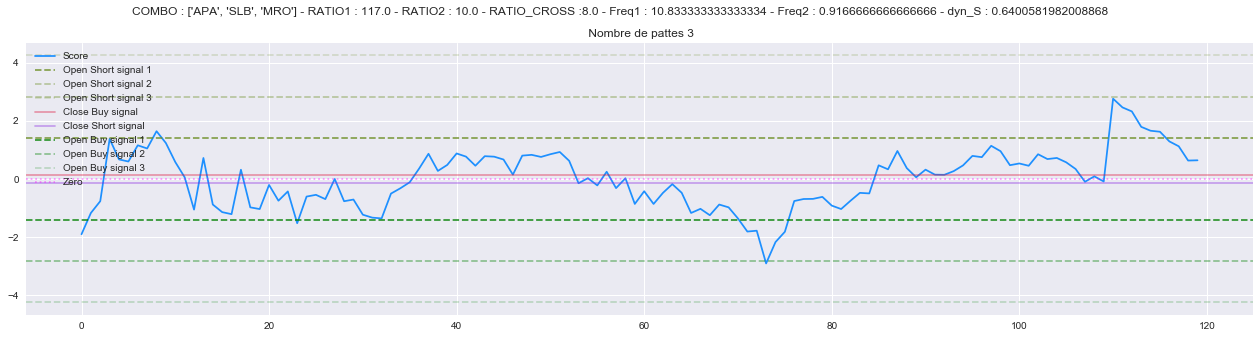

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['BKR', 'SLB', 'DVN'] 


Heure locale du début du train :  2020-08-12 17:09:36 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour BKR
Passage pour SLB
Passage pour DVN
 BKR   a un kmo considéré comme   adéquat 
 SLB   a un kmo considéré comme   adéquat 
 DVN   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : BKR
SLB  - coef :  0.16993136465788494
DVN  - coef :  0.5225587785463932
TICKERS :  ['BKR', 'SLB', 'DVN']
COEF [0.16993136 0.52255878]
CSTE 5.797571200152872
Dernière valeur du combo à  15.833755834997882
Derniere valeur du residu 1.6162449279415707
Dernière valeur du Score 1.4883267633392143
Mean 5.329070518200751e-16
Std 1.085947634453175
 Pour les TICKERS 

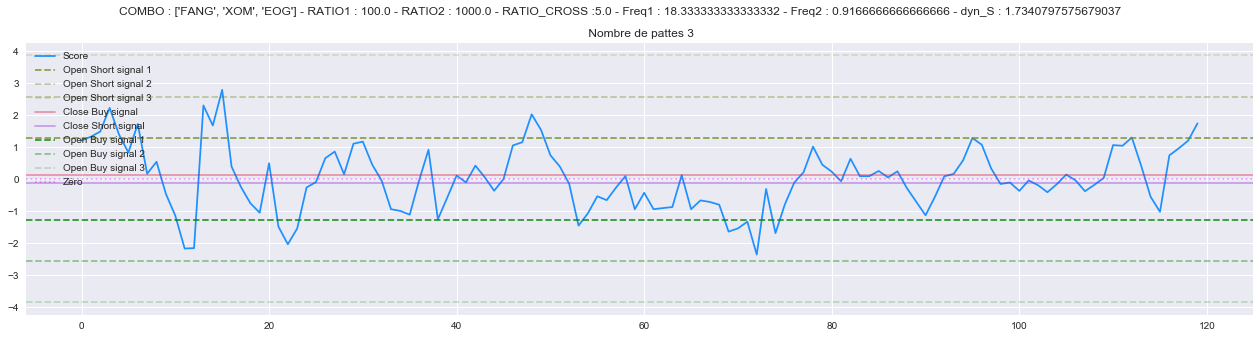

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['EOG', 'CXO', 'MRO'] 


Heure locale du début du train :  2020-08-12 17:10:02 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour EOG
Passage pour CXO
Passage pour MRO
 EOG   a un kmo considéré comme   adéquat 
 CXO   a un kmo considéré comme   adéquat 
 MRO   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : EOG
CXO  - coef :  0.39387021644785325
MRO  - coef :  3.711911807953448
TICKERS :  ['EOG', 'CXO', 'MRO']
COEF [0.39387022 3.71191181]
CSTE 6.165371713765801
Dernière valeur du combo à  49.907855074012055
Derniere valeur du residu 0.03214355269692959
Dernière valeur du Score 0.017071171911732557
Mean 1.7763568394002505e-15
Std 1.8829142406349042
 Pour les TICK

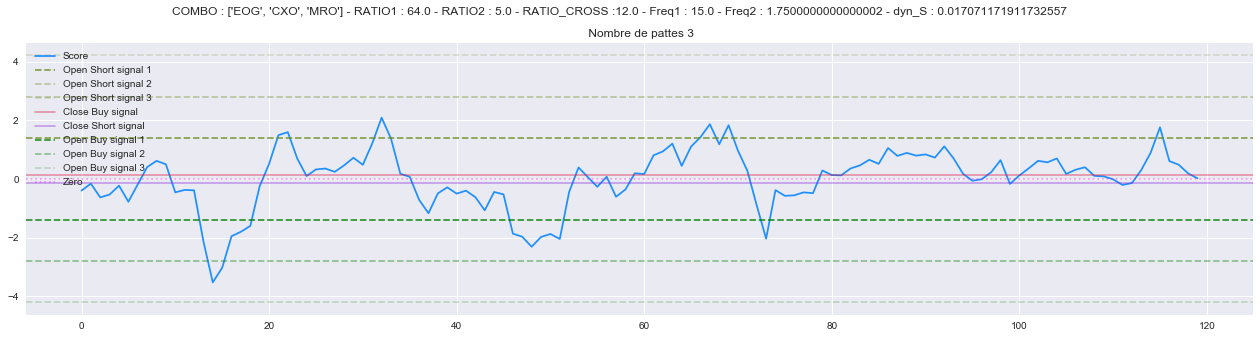

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['XOM', 'FANG', 'MRO'] 


Heure locale du début du train :  2020-08-12 17:10:09 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour XOM
Passage pour FANG
Passage pour MRO
 XOM   a un kmo considéré comme   adéquat 
 FANG   a un kmo considéré comme   adéquat 
 MRO   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : XOM
FANG  - coef :  0.4946108669890062
MRO  - coef :  -0.6345054366335536
TICKERS :  ['XOM', 'FANG', 'MRO']
COEF [ 0.49461087 -0.63450544]
CSTE 27.71181328452399
Dernière valeur du combo à  46.32736471625127
Derniere valeur du residu -2.18736532660283
Dernière valeur du Score -1.614548942072893
Mean 3.315866100213801e-15
Std 1.3547841564929648
 Pour les TI

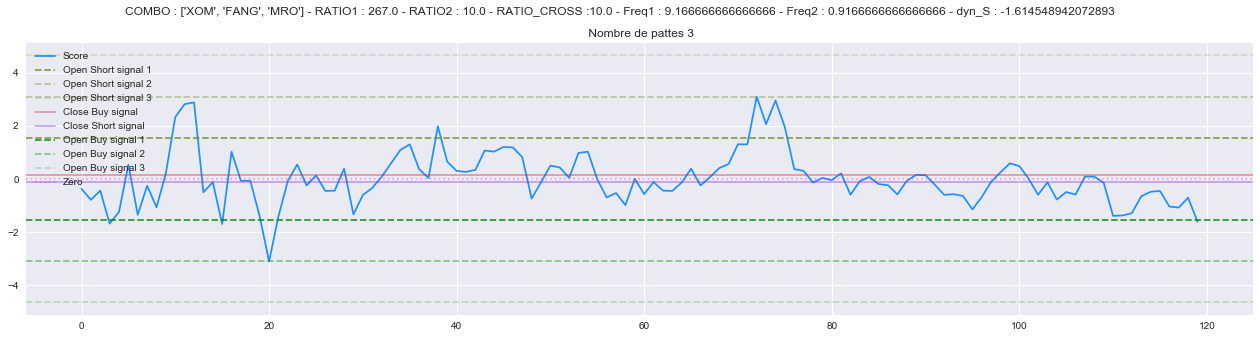

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['HAL', 'NOV', 'SLB'] 


Heure locale du début du train :  2020-08-12 17:10:16 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour HAL
Passage pour NOV
Passage pour SLB
 HAL   a un kmo donsidéré comme   inadéquat 
 NOV   a un kmo donsidéré comme   inadéquat 
 SLB   a un kmo donsidéré comme   inadéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : HAL
NOV  - coef :  -0.9662555659847183
SLB  - coef :  1.4536549512855899
TICKERS :  ['HAL', 'NOV', 'SLB']
COEF [-0.96625557  1.45365495]
CSTE -3.080798864263457
Dernière valeur du combo à  13.47997422196243
Derniere valeur du residu 3.0618253233256567
Dernière valeur du Score 2.193984007296788
Mean -8.733754460384564e-16
Std 1.3955549872481243
 Pour les

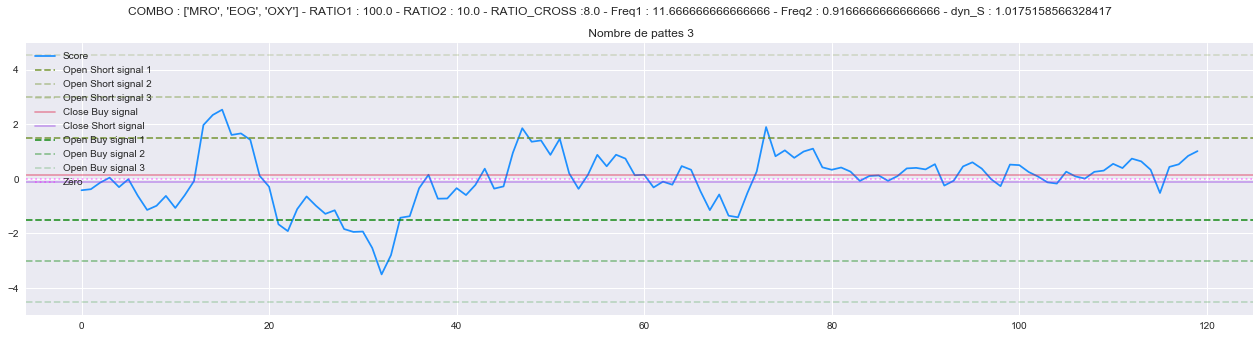

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['MPC', 'SLB', 'NOV'] 


Heure locale du début du train :  2020-08-12 17:10:36 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour MPC
Passage pour SLB
Passage pour NOV
 MPC   a un kmo considéré comme   adéquat 
 SLB   a un kmo donsidéré comme   inadéquat 
 NOV   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : MPC
SLB  - coef :  3.11030860014732
NOV  - coef :  -1.7028013610263244
TICKERS :  ['MPC', 'SLB', 'NOV']
COEF [ 3.1103086  -1.70280136]
CSTE -2.2992377129555592
Dernière valeur du combo à  37.94463395400565
Derniere valeur du residu 0.07536650375801912
Dernière valeur du Score 0.025464343778422823
Mean -4.085620730620576e-15
Std 2.959687648494791
 Pour les T

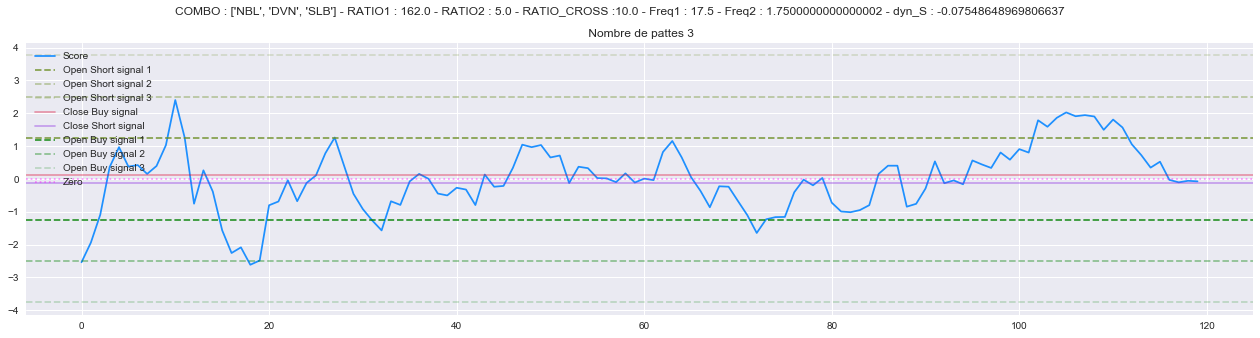

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['OXY', 'MRO', 'EOG'] 


Heure locale du début du train :  2020-08-12 17:10:49 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour OXY
Passage pour MRO
Passage pour EOG
 OXY   a un kmo considéré comme   adéquat 
 MRO   a un kmo considéré comme   adéquat 
 EOG   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 70
Paire principale : OXY
MRO  - coef :  3.7990070797431597
EOG  - coef :  -0.013264237633973152
TICKERS :  ['OXY', 'MRO', 'EOG']
COEF [ 3.79900708 -0.01326424]
CSTE -3.590893281619426
Dernière valeur du combo à  18.82565799399221
Derniere valeur du residu -3.5056582991679903
Dernière valeur du Score -1.22912018245122
Mean 2.930988785010413e-15
Std 2.852168851524918
 Pour les TICK

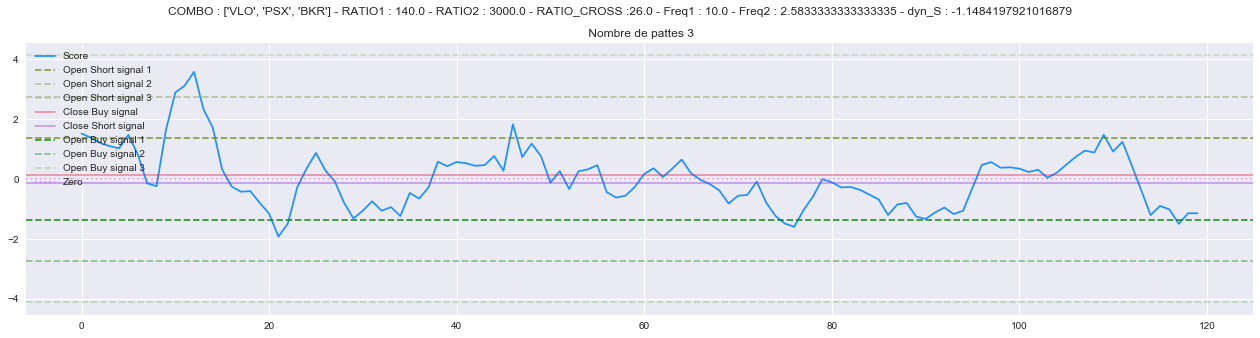

base_pair0 [PAIRE PRINCIPALE]:  (522, 1)
base_pair1 :  (522, 1)
base_pair2 :  (522, 1)

Analyse du pack : ['WMB', 'XOM', 'FANG'] 


Heure locale du début du train :  2020-08-12 17:11:16 

 
 
|||| TIME_FRAME <---> debut : 2020-02-24 00:00:00  <---> split :  2020-08-12 00:00:00

Récupération pair0 =>  (120, 2)
Récupération pair1 =>  (120, 2)
Récupération pair2 =>  (120, 2)
Longueur de PAIR (liste des pair) 3
Passage pour WMB
Passage pour XOM
Passage pour FANG
 WMB   a un kmo considéré comme   adéquat 
 XOM   a un kmo considéré comme   adéquat 
 FANG   a un kmo considéré comme   adéquat 
  


LIGNE 456


 
SCORE > 50
XOM  :  0.09108965601386443
TICKERS :  ['WMB', 'XOM', 'FANG']
COEF [0.23071621 0.09108966]
CSTE 4.379045238762716
Dernière valeur du combo à  18.70106171668773
Derniere valeur du residu 2.9489379018425446
Dernière valeur du Score 1.8017171564986498
Mean -1.0362081563168128e-15
Std 1.636737426407892
 Pour les TICKERS : ['WMB', 'XOM', 'FANG'] , - Moyenne du spread : -1.0362081

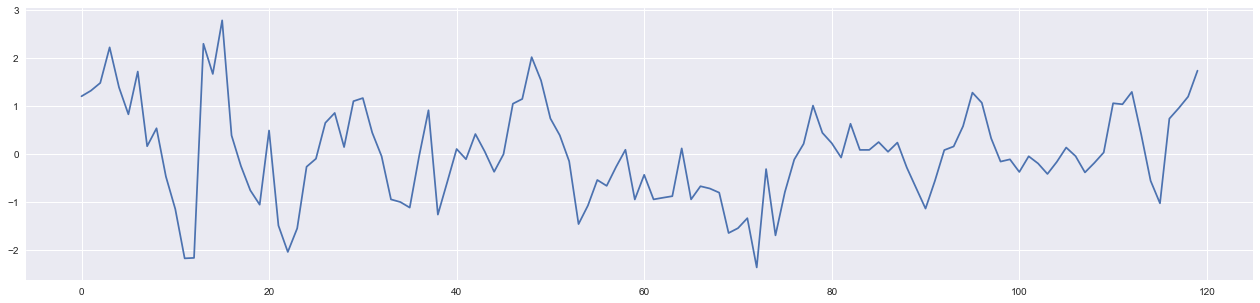

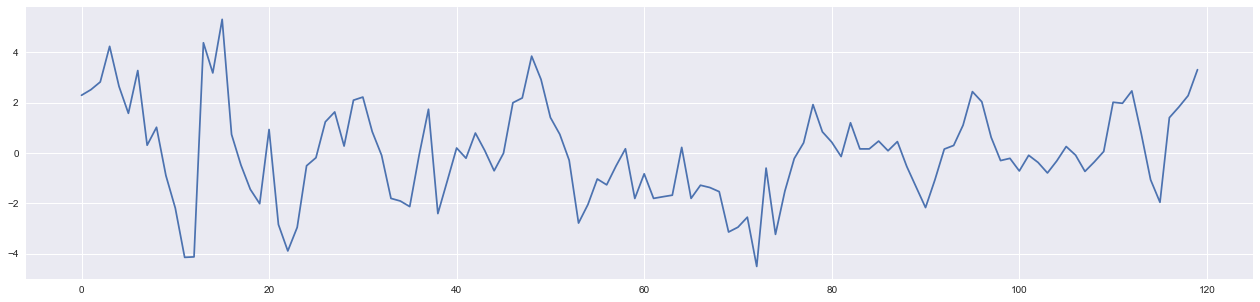

Souscription aux données de Marché...

 A VERIFIER POUR EVENTUELLE IMPLEMENTATION


La mise est établie à 100000 


CALCUL DU DYNAMIC SCORE
   C A L C U L    D E    D Y N _ S  
Rappel des TICKERS ['FANG', 'XOM', 'EOG']
Rappel des coef [0.64919226 0.93807147]
Rappel de cste -33.380037580615465
Rappel du std 1.9072963602708157
Rappel du mean 1.7763568394002505e-15


TAILLES DES POSITIONS (coef x mise en kilo devise):
Pour rappel les coef sont à  [0.64919226 0.93807147]
les tickers sont ['FANG', 'XOM', 'EOG']
la constante est cste -33.380037580615465
et la mise : 100000



Derniers closes après transfo en $:


KeyError: 'dynf0'

In [8]:
main_func(D)

In [190]:
%%time
ib.reqHistoricalTicks(contract=contract, startDateTime='', endDateTime=dt.datetime.now(), numberOfTicks = 5, whatToShow='Trades', useRth=False)

Peer closed connection
Future exception was never retrieved
future: <Future finished exception=ConnectionError('Socket disconnect')>
ConnectionError: Socket disconnect


ConnectionError: Socket disconnect

In [152]:
dt.datetime.now()

datetime.datetime(2020, 8, 12, 23, 15, 1, 652517)

In [184]:
ib.reqMarketDataType(2)

#  1 = Live

# 2 = Frozen

# 3 = Delayed

# 4 = Delayed frozen

In [185]:
ib.reqMktData(contract, genericTickList='', snapshot=False, regulatorySnapshot=False, mktDataOptions=None)

Ticker(contract=Stock(conId=208813720, symbol='GOOG', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='GOOG', tradingClass='NMS'))

In [188]:
ib.reqMktData(contract=contract, genericTickList='294', snapshot=True, regulatorySnapshot=False, mktDataOptions=None)

Ticker(contract=Stock(conId=208813720, symbol='GOOG', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='GOOG', tradingClass='NMS'))

8


In [ ]:
D = shelve.open('varlog') 
for key,val in D.items():
    exec(key + '=val') 
D.close()

acsum = ib.run(acsummcoro(ib))

In [ ]:




def shoot(D):
    global nbre_trade, PAIR, mise, mise0, mise1, mise2, mise3, mise4, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,m0,m1,m2,m3,m4,take_profit,usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq,_spread,OPEN_POZ
    
    _spread = 0
    for x in range(nb_pattes):
        if TICKERS[x] == 'BTC/USD':
            globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
            globals()['mise%s' % x] = mise / 100
        elif TICKERS[x] == 'USD/ZAR':
            globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
            globals()['mise%s' % x] = mise / 1000
        elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
            globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
            globals()['mise%s' % x] = mise / 10
        elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
        or TICKERS[x] == 'LTC/USD':
            
            globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
            globals()['mise%s' % x] = mise
        else:
            globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
            globals()['mise%s' % x] = mise / 1000

    for x in range(nb_pattes):
        try:
            if '/USD' in TICKERS[0]:
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
            _spread = _spread + delta0
            
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                    
                if 'USD/' in TICKERS[x]:
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)

                globals()['delta%s' % x] = globals()['delta%s' % x] * (coef[x-1])
                _spread = _spread + (globals()['delta%s' % x])

            except:
                print(TICKERS[x],' => NON VALIDE')


    for key,val in D.items():
        exec(key + '=val')

    print('Le coût du spread en $ est de :',_spread)

    print('\n\n')
    print(Back.YELLOW,Fore.BLACK,'./\_-°oO-_____S H O O T_____-Oo°-_./\\',Style.RESET_ALL)
    
    if dyn_S > lim_s1 and dyn_S < lim_s2 and _os == 0 and ol == 0 and sell1 == 0 and sell2 == 0 and sell3 == 0 :
        _os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 1
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        sens = 'SHORT 1'
        try:
            son = pygame.mixer.Sound(".mp3")
            son.play()
        except:
            engine.say("bim!, on shoot short, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em shorts 1 on account '+str(compte))
        
        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)

        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                    
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
                
            except:
                print(TICKERS[x],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        for x in range(nb_pattes):
            if abs(globals()['m%s' % x]) < 1:
                print(Fore.RED,'\n A L E R T E  = > Q U A N T I T E    I N F E R I E U R E    A     1    P O U R    :    m%s' % x,Style.RESET_ALL)
                globals()['m%s' % x] = 1      
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        
        
        for x in range(1,nb_pattes):
            
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
        
        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ
            

        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        print(con.get_open_positions_summary().T)

    elif dyn_S >= lim_s2 and dyn_S < lim_s3 and ol == 0 and sell2 == 0 and sell3 == 0:
        _os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 1
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        sens = 'SHORT 2'

        try:
            son = pygame.mixer.Sound(".mp3")
            son.play()
        except:
            engine.say("bim!, on shoot short, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em shorts 2 on account '+str(compte))

        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            except:
                print(TICKERS[1],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        for x in range(nb_pattes):
            if abs(globals()['m%s' % x]) < 1:
                globals()['m%s' % x] = 1      
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        

        for x in range(1,nb_pattes):
            
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))

        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        print(con.get_open_positions_summary().T)

    elif dyn_S >= lim_s3 and dyn_S < abs(amplitude) and ol == 0 and sell3 == 0:
        _os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 1
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        sens = 'SHORT 3'

        try:
            son = pygame.mixer.Sound("open_short.mp3")
            son.play()
            joue = 1
        except:
            engine.say("bim!, on shoot short, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em shorts 3 on account '+str(compte))

        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            except:
                print(TICKERS[1],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        for x in range(nb_pattes):
            if abs(globals()['m%s' % x]) < 1:
                globals()['m%s' % x] = 1      
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))

        
        for x in range(1,nb_pattes):
            
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))

        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        print(con.get_open_positions_summary().T)

    elif dyn_S < lim_cs and _os == 1 :
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'On Signal Close',Style.RESET_ALL)
        
        try:
            son = pygame.mixer.Sound("nat_close.mp3")
            son.play()
        except:
            engine.say("bim!, on koope natural close, ta vu?, wesh?, I need money")
            engine.runAndWait()
        sms('FX_Go!em closes by signal on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')
        print(con.get_closed_positions_summary().T)
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)

        
    elif dyn_net_pnl > take_profit and _os == 1 : 
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Take Profit Close',Style.RESET_ALL)
        
        try:
            son = pygame.mixer.Sound("tp_close.mp3")
            son.play()
        except:
            engine.say("bim!, on koope take profit, ta vu?, wesh?, I need money")
            engine.runAndWait()
        
        sms('FX_Go!em closes by take profit on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')
        print(con.get_closed_positions_summary().T)
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)


    elif dyn_S > abs(amplitude * 1.20) and _os == 1 :
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'STOP LOSS CLOSE',Style.RESET_ALL)
        
        try:
            son = pygame.mixer.Sound("sl_close.mp3")
            son.play()
        except:
            engine.say("bim!,bordel, on koope stop loss, ta vu?, wesh?, cé la graus merd")
            engine.runAndWait()
        sms('FX_Go!em closes by stop loss on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')
        print(con.get_closed_positions_summary().T)
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)
        

    elif dyn_S < lim_l1 and dyn_S > lim_l2 and _os == 0 and ol == 0 and buy1 == 0 and buy2 == 0 and buy3 == 0:
        _os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 1
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 1
        sens = 'LONG 1'
        
        try:
            son = pygame.mixer.Sound("open_long.mp3")
            son.play()
        except:
            engine.say("bim!, on shoot long, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em longs 1 on account '+str(compte))

        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            except:
                print(TICKERS[1],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))

        
        for x in range(1,nb_pattes):
            if x == 0:
                continue
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))

        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
               
        print(con.get_open_positions_summary().T)

    elif dyn_S <= lim_l2 and dyn_S > lim_l3 and _os == 0 and buy2 == 0 and buy3 == 0 :
        _os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 1
        buy3 = 0
        nbposs = 0
        nbposl = 1
        sens = 'LONG 2'

        try:
            son = pygame.mixer.Sound("open_long.mp3")
            son.play()
        except:
            engine.say("bim!, on shoot long, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em longs 2 on account '+str(compte))

        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL)
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            except:
                print(TICKERS[1],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))

        
        for x in range(1,nb_pattes):
            if x == 0:
                continue
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))

        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
               
        print(con.get_open_positions_summary().T)

    elif dyn_S <= lim_l3 and dyn_S > -abs(amplitude) and _os == 0 and buy3 == 0 :
        _os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 1
        nbposs = 0
        nbposl = 1
        sens = 'LONG 3'

        try:
            son = pygame.mixer.Sound("open_long.mp3")
            son.play()
        except:
            engine.say("bim!, on shoot long, ta vu?, wesh?, gé pri tro la confianse")
            engine.runAndWait()
        sms('FX_Go!em longs 3 on account '+str(compte))

        D['_os'] = _os
        D['ol'] = ol
        D['cl'] = cl
        D['cs'] = cs
        D['sell1'] = sell1
        D['sell2'] = sell2
        D['sell3'] = sell3
        D['buy1'] = buy1
        D['buy2'] = buy2
        D['buy3'] = buy3
        D['nbposs'] = nbposs
        D['nbposl'] = nbposl
        D['sens'] = sens
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL)
        
        for x in range(nb_pattes):
            if TICKERS[x] == 'BTC/USD':
                globals()['mise%s' % x] = mise / 100
            elif TICKERS[x] == 'USD/ZAR':
                globals()['mise%s' % x] = mise / 1000
            elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
                globals()['mise%s' % x] = mise / 10
            elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
            or TICKERS[x] == 'LTC/USD':
                globals()['mise%s' % x] = mise
            else:
                globals()['mise%s' % x] = mise / 1000

        print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
        try:
            if '/USD' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0)
                m0 = mise0
            if 'USD/' in TICKERS[0]:
                print(TICKERS[0],' : ', mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
                m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        except:
            print(TICKERS[0],' => NON VALIDE')

        for x in range(nb_pattes):
            if x == 0:
                continue
            try:
                if '/USD' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                if 'USD/' in TICKERS[x]:
                    print(TICKERS[x],' : ', globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2))
                    globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)
            except:
                print(TICKERS[1],' => NON VALIDE')
        
        print('\n')

        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = con.create_market_buy_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))
        elif 'USD/' in TICKERS[0]:
            p0os = con.create_market_sell_order(TICKERS[0],abs(m0))
            print('Taille pour',TICKERS[0],' : ',abs(m0))

        
        for x in range(1,nb_pattes):
            if x == 0:
                continue
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_buy_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))
                elif 'USD/' in TICKERS[x]:
                    globals()['p%sos' % x] =  con.create_market_sell_order(TICKERS[x],abs(round(globals()['m%s' % x],4)))
                    print('Taille pour',TICKERS[x],' : ',abs(round(globals()['m%s' % x],4)))

        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x].get_tradeId()
            time.sleep(1)
            OPEN_POZ.append(globals()['p%sos' % x].get_tradeId())

        D['OPEN_POZ'] = OPEN_POZ

        for key,val in D.items():
            exec(key + '=val')
        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()
               
        print(con.get_open_positions_summary().T)

    elif dyn_S > lim_cl and ol == 1 :
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'On Signal Close',Style.RESET_ALL)
        
        try:
            son = pygame.mixer.Sound("nat_close.mp3")
            son.play()
        except:
            engine.say("bim!, on koope natural close, ta vu?, wesh?, I need money")
            engine.runAndWait()
        sms('FX_Go!em closes by signal on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')
    
        print('\n',con.get_closed_positions_summary().T)

        nbre_trade += 1
        nbre_trade_long +=1
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_long'] = nbre_trade_long
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)

    elif dyn_net_pnl > take_profit and ol == 1 :
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Take Profit Close',Style.RESET_ALL)

        try:
            son = pygame.mixer.Sound("tp_close.mp3")
            son.play()
        except:
            engine.say("bim!, on koope take profit, ta vu?, wesh?, I need money")
            engine.runAndWait()
        sms('FX_Go!em closes by take profit on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')
    
        print('\n',con.get_closed_positions_summary().T)

        nbre_trade += 1
        nbre_trade_long +=1
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_long'] = nbre_trade_long
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)

    elif dyn_S < -abs(amplitude * 1.20) and ol == 1 :
        
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'STOP LOSS CLOSE',Style.RESET_ALL)
        
        try:
            son = pygame.mixer.Sound("sl_close.mp3")
            son.play()
        except:
            engine.say("bim!,bordel, on koope stop loss, ta vu?, wesh?, cé la graus merd")
            engine.runAndWait()
        sms('FX_Go!em closes by stop loss on account '+str(compte))

        D = close_all(D)
        for key,val in D.items():
            exec(key + '=val')

        print('\n',con.get_closed_positions_summary().T)

        nbre_trade += 1
        nbre_trade_long +=1
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_long'] = nbre_trade_long
        for key,val in D.items():
            exec(key + '=val')
        
        #D = main_func(D)

        print('\nSauvegarde du ficher Log\n')
        d = shelve.open('varlog_Energy')
        d['D'] = D 
        d.close()

    else:
        print('\n NONE ===> ITERATION SUIVANTE\n')

    return(D)
    

def close_all(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,take_profit,usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2,OPEN_POZ

    for key,val in D.items():
        exec(key + '=val')
    
    try:
        dyn_net_pnl = 0
        for x in OPEN_POZ:
            dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
    except:
        dyn_net_pnl = 9999999999
        print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
    if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
        print('\r'+Fore.GREEN+'Dynamic NET PNL :',round(dyn_net_pnl,2),'€ --- ',len(con.get_open_positions())/nb_pattes,'couches'+Style.RESET_ALL,'\n')
    elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
        print('\r'+Fore.RED+'Dynamic NET PNL :',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches'+Style.RESET_ALL,'\n')
    try:
        print('Le dyn_S à la clotûre des positions est de :',dyn_S)
    except:
        pass

    for x in OPEN_POZ:
        con.get_open_position(str(x)).close()
    
    break_it = 0
    stop = 0
    full_stop = 1

    sens = 'INIT'
    name = 'INIT'

    _os = 0
    ol = 0
    cs = 0
    cl = 0
    buy1 = 0
    buy2 = 0
    buy3 = 0
    sell1 = 0
    sell2 = 0
    sell3 = 0
    nbposs = 0
    nbposl = 0
    nbpos = 0
    pnll = 0
    pnls = 0
    dyn_net_pnl = 0
    amplitude = 0
    cste = 0
    mise = 0
    mise0 = 0
    mise1 = 0
    mise2 = 0
    mise3 = 0
    mise4 = 0
    dyn_S = 0
    dynf = 0
    _mean = 0
    _std = 0
    big_len = 0
    chi_square_value = 0
    p_value = 0
    ev = 0
    v = 0
    jh_results = 0
    v1 = 0
    v2 = 0
    skew = 0
    kurtosis = 0
    full_stop = 0
    residu = 0

    p0os = 0
    p1os = 0
    p2os = 0
    p3os = 0
    p4os = 0
    
    deviamax = 0
    usable_margin = 999.99

    debut = dt.date(1,1,1)
    fin = dt.date(1,1,1)
    split = dt.date(1,1,1)

    base_pair0 = pd.DataFrame()
    base_pair1 = pd.DataFrame()
    base_pair2 = pd.DataFrame()
    base_pair3 = pd.DataFrame()
    base_pair4 = pd.DataFrame()
    pair = pd.DataFrame()
    pair0 = pd.DataFrame()
    pair1 = pd.DataFrame()
    pair2 = pd.DataFrame()
    pair3 = pd.DataFrame()
    pair4 = pd.DataFrame()
    daf = pd.DataFrame()
    dynamic_combo = pd.DataFrame()
    dynamic_residu = pd.DataFrame()
    combo = pd.DataFrame()

    coef = []
    S = []
    PAIR = []
    CSTE = []
    DYNS = []
    TICKERS = []
    BIG_TICKERS = []
    TIME_FRAME = []
    INDEX = []
    INSTRUMENTS = []
    PACK = []
    SL_PACK = []
    SHORT_LIST = []
    OPEN_POZ = []


    D = {}
    D = {'_os':_os, 'ol':ol, 'cs':cs, 'cl':cl, 'buy1':buy1, 'buy2':buy2, 'buy3':buy3, 'sell1':sell1, 'sell2':sell2, 'sell3':sell3, 'nbposs':nbposs, 'nbposl':nbposl, 'nbpos':nbpos, 'nbre_trade':nbre_trade, 'nbre_trade_long':nbre_trade_long, 'nbre_trade_short':nbre_trade_short, 'pnll':pnll, 'pnls':pnls, 'amplitude':amplitude, 'cste':cste, 'mise':mise, 'mise0':mise0, 'mise1':mise1, 'mise2':mise2, 'mise3':mise3, 'mise4':mise4, 'mark':mark, 'lim_s1':lim_s1, 'lim_s2':lim_s2, 'lim_s3':lim_s3, 'lim_l1':lim_l1, 'lim_l2':lim_l2, 'lim_l3':lim_l3, 'lim_cs':lim_cs, 'lim_cl':lim_cl, 'dyn_S':dyn_S, '_mean':_mean, '_std':_std, 'big_len':big_len, 'chi_square_value':chi_square_value, 'p_value':p_value, 'ev':ev, 'v':v, 'jh_results':jh_results, 'v1':v1, 'v2':v2, 'skew':skew, 'kurtosis':kurtosis, 'dynf':dynf, 'residu':residu, 'p0os':p0os, 'p1os':p1os, 'p2os':p2os, 'p3os':p3os, 'p4os':p4os, 'debut':debut, 'fin':fin, 'split':split, 'base_pair0':base_pair0, 'base_pair1':base_pair1, 'base_pair2':base_pair2, 'base_pair3':base_pair3, 'base_pair4':base_pair4, 'pair':pair, 'pair0':pair0, 'pair1':pair1, 'pair2':pair2, 'pair3':pair3, 'pair4':pair4, 'coef':coef, 'S':S, 'PAIR':PAIR, 'CSTE':CSTE, 'DYNS':DYNS, 'TICKERS':TICKERS, 'BIG_TICKERS':BIG_TICKERS, 'TIME_FRAME':TIME_FRAME, 'INDEX':INDEX, 'INSTRUMENTS':INSTRUMENTS, 'PACK':PACK, 'SL_PACK':SL_PACK, 'SHORT_LIST':SHORT_LIST, 'TOKEN':TOKEN, 'server':server, 'user_id':user_id, 'compte':compte, 'password':password, 'period':period, 'number':number, 'invers':invers, 'diloug':diloug, 'break_it':break_it, 'stop':stop, 'full_stop':full_stop, 'sens':sens, 'name':name, 'dyn_net_pnl':dyn_net_pnl, 'deviamax':deviamax,'take_profit':take_profit,'nb_pattes':nb_pattes}

    balance = con.get_accounts().balance
    balance = balance[0]
    equity = con.get_accounts().equity
    equity = equity[0]
    resum = con.get_open_positions()
    usable_margin = con.get_accounts_summary().usableMargin3Perc[0]
    D['balance'] = balance
    D['equity'] = equity
    D['usable_margin'] = usable_margin
    
    print('Balance : ',balance)

    print('Equity : ',equity)

    print('Marge disponible ;',usable_margin,'%')

    for key,val in D.items():
        exec(key + '=val')
    
    print('Remise à 0 et sauvegarde du ficher Log')
    d = shelve.open('varlog_Energy')
    d['D'] = D 
    d.close()
    main_func(D)
    return(D)




def continuum(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, diloug, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu, take_profit, usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2,OPEN_POZ
    sms('FX_Go!em is engaging CONTINUUM on account '+str(compte))
    print('###############################################\n############## C O N T I N U U M ##############\n###############################################')

    ########################################################
    ##### APRES DECONNEXION ################################
    ########################################################
    
    for key,val in D.items():
        exec(key + '=val')
    
    ################################################
    ### BOUCLE DE CONTROLE ET PASSAGE DES ORDRES ###
    ################################################
    print('Souscription aux données de Marché...')

    for x in range(nb_pattes):
        con.subscribe_market_data(TICKERS[x])
        con.subscribe_instrument(TICKERS[x])
    
    print('La mise est de',mise,'$')
    print('La marge utilisable',usable_margin,'%')
    print('Les variables _os, ol, sell1, sell2, sell3, buy1, buy2, buy3, cs, cl sont de : ',_os, ol, sell1, sell2, sell3, buy1, buy2, buy3, cs, cl)

    print('Les Tickers sont :',TICKERS)
    print('Les coef sont',coef)

    print('\nLa mise est établie à',mise,'\n')
    
    print('\nLa mise est établie à',mise,'\n')
    
    print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
    D = new_dyns(D)
    for key,val in D.items():
        exec(key + '=val')
        
    print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL,'\n')
    
    try:
        dyn_net_pnl = 0
        for x in OPEN_POZ:
            dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
    except:
        dyn_net_pnl = 9999999999
        print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
    if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
    elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
    
    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
    
    D = shoot(D)
    for key,val in D.items():
        exec(key + '=val')
    print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre",'\n')
    try:
        dyn_net_pnl = 0
        for x in OPEN_POZ:
            dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
    except:
        dyn_net_pnl = 0
    if dyn_net_pnl >0:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')            
    elif dyn_net_pnl <0:
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')

        print('\nEntrée dans la boucle...\n')

    for loop in range(0,72000000):

        try:
            dyn_net_pnl = 0
            for x in OPEN_POZ:
                dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
        except:
            dyn_net_pnl = 9999999999
            print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
        if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
            print('\r'+Fore.GREEN+'Dynamic PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
        elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
            print('\r'+Fore.RED+'Dynamic PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')

        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
        print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
        D = new_dyns(D)
        for key,val in D.items():
            exec(key + '=val')
        print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL)
        D = shoot(D)
        for key,val in D.items():
            exec(key + '=val')
        print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre")
        
        for timer in range(4):
            try:
                dyn_net_pnl = 0
                for x in OPEN_POZ:
                    dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
            except:
                dyn_net_pnl = 0
                print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='',flush=True)
            if dyn_net_pnl >0:
                print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Fore.GREEN+'Dynamic PNL ('+str(sens)+'): '+str(round(dyn_net_pnl,2))+'€ ---'+str(len(con.get_open_positions())/nb_pattes)+'couches \n'+Style.RESET_ALL,end='',flush=True)            
            elif dyn_net_pnl <0:
                print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' - '+Fore.RED+'Dynamic NET PNL ('+str(sens)+'): '+str(round(dyn_net_pnl,2))+'€ ---'+str(len(con.get_open_positions())/nb_pattes)+'couches \n'+Style.RESET_ALL,end='',flush=True)

            if dyn_net_pnl >= take_profit :
                close_all(D)
            time.sleep(30)
                    
    for key,val in D.items():
        exec(key + '=val')
    return()

def sms(_message_):
    '''client = Client(account_sid, auth_token)

    message = client.messages \
                    .create(
                        body=_message_,
                        from_='+12019072085',
                        to='+33612550269')'''
    _message_ = _message_
    return()


engine.say("functions initiated")
engine.runAndWait()
print('Functions initiated')

In [ ]:




#########################
####### OPERATIVE #######
#########################
for loop in range(72000):
    #try:
    try:
        son = pygame.mixer.Sound("uograde.mp3")
        son.play()
    except:
        engine.say("ep grade dé daunai")
        engine.runAndWait()
    balance = con.get_accounts().balance
    balance = balance[0]
    equity = con.get_accounts().equity
    equity = equity[0]
    resum = con.get_open_positions()
    usable_margin = con.get_accounts_summary().usableMargin3Perc[0]
    D['balance'] = balance
    D['equity'] = equity
    D['usable_margin'] = usable_margin

    print('Balance : ',balance)

    print('Equity : ',equity)

    print('Marge disponible ;',usable_margin,'%')

    for key,val in D.items():
        exec(key + '=val')

    if len(resum) == 0:
        print('\nPas de position actuellement en cours. Vous pouvez procéder à la suite\n')
        print(Fore.BLUE,'\nNombre de pattes ',nb_pattes,'\n',Style.RESET_ALL)
        sms('FX_Go!em begins new train on account '+str(compte))
        try:
            son = pygame.mixer.Sound(".mp3")
            son.play()
            son = pygame.mixer.Sound(".mp3")
            son.play()
            son = pygame.mixer.Sound(".mp3")
            son.play()
        except:
            engine.say("שמירת הלשון?")
            engine.say("ranafoot")
            engine.say("avec Jyss, sa glis")
            engine.runAndWait()
        main_func(D)

    else:
        _answer = 'non'
        _answer = input('Doit-on récupérer les données? (oui - non)')
        if _answer == 'oui' or _answer == 'OUI' or _answer == 'O' or _answer == 'o' or _answer == 'Oui':
            try:
                print('Récupération des données du Log')
                d = shelve.open('varlog_Energy')
                for key,val in d.items():
                    exec(key + '=val') 
                for key,val in D.items():
                    exec(key + '=val')
                d.close()

                try:
                    dyn_net_pnl = 0
                    for x in OPEN_POZ:
                        dyn_net_pnl += con.get_open_position(str(x)).get_grossPL()
                
                except:
                    dyn_net_pnl = 0
                if dyn_net_pnl >0:
                    print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€ --- ',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')            
                elif dyn_net_pnl <0:
                    print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€ --- ',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
                print('Liste Combo récupérés',TICKERS)
                print('Reprise de la boucle en mode continuum')
                print(Fore.BLUE,'\nNombre de pattes \n',nb_pattes,Style.RESET_ALL)
                
                try:
                    son = pygame.mixer.Sound("chmirat.mp3")
                    son.play()
                    son = pygame.mixer.Sound("ra_foot.mp3")
                    son.play()
                    son = pygame.mixer.Sound("jyss.mp3")
                    son.play()
                except:
                    engine.say("שמירת הלשון?")
                    engine.say("ranafoot")
                    engine.say("avec Jyss, sa glis")
                    engine.runAndWait()

                continuum(D)


            except:
                print(Back.BLACK,Fore.YELLOW,'/!\ ATTENTION /!\ On ne trouve pas de pas de fichier Log. Du coup, on repart à 0. Vérifier tout de même.\
                 On repart de 0!')
                main_func(D)

        else:
            print(Back.BLACK,Fore.YELLOW,'/!\ ATTENTION /!\ On ne récupère pas de pas de fichier Log. Du coup, on repart à 0. Vérifier tout de même')
            
            print(Fore.BLUE,'\nNombre de pattes ',nb_pattes,'\n',Style.RESET_ALL)
            
            try:
                os.remove('varlog01215059.bak')
            except:
                print('Fichier varlog01215059.bak non effacé')
            
            try:
                os.remove('varlog01215059.dat')
            except:
                print('Fichier varlog01215059.dat non effacé')
            
            try:
                os.remove('varlog01215059.dir')
            except:
                print('Fichier varlog01215059.dir non effacé')
            
            if (len(resum)%nb_pattes) != 0:
                print(Back.LIGHTYELLOW_EX,Fore.BLACK,'\nAnomalie détectée. Contrôle tes posoitions conseillé\n',Style.RESET_ALL)
                sms('FX_Go!em detects anomaly on account '+str(compte))
                try:
                    son = pygame.mixer.Sound("mank_patt.mp3")
                    son.play()

                    son = pygame.mixer.Sound("chmirat.mp3.mp3")
                    son.play()
                    son = pygame.mixer.Sound("ra_treuf.mp3")
                    son.play()
                    son = pygame.mixer.Sound("jyss.mp3")
                    son.play()
                except:
                    engine.say("pitun cé la merd, el munk dé  pat, tutai neekai ")
                    engine.runAndWait()
                    
                    engine.say("שמירת הלשון?")
                    engine.say("ranafoot")
                    engine.say("avec Jyss, sa glis")
                    engine.runAndWait()

            main_func(D)
        
'''
    except:
        print('Avarie')
        try:
            son = pygame.mixer.Sound("failed1.mp3")
            son.play()
            son = pygame.mixer.Sound("failed2.mp3")
            son.play()
            son = pygame.mixer.Sound("failed3.mp3")
            son.play()
            son = pygame.mixer.Sound("fail4.mp3")
            son.play()
        except:
            engine.say("failed, sa mer la pitit put de salaup an slip ble, devan le prizunic")
            engine.say("שמירת הלשון?")
            engine.say("ranafoot, I tell wahat I want, tu konpran sa??")
            engine.say("aipee, detlai manier, manfu, avec Jyss, sa glis")
            engine.runAndWait()
            sms('Problème détecté par le FX_Go!em sur le compte '+str(compte))
'''

In [ ]:
len(OPEN_POZ),OPEN_POZ,BIG_TICKERS

In [ ]:
con.get_accounts().equity

In [ ]:
dyn_net_pnl

In [ ]:
con = conX()

In [ ]:
close_all(D)

In [ ]:
from tkinter import *
window = Tk()
window.title("Welcome to LikeGeeks app")
lbl = Label(window, text="Hello")
lbl.grid(column=0, row=0)
window.mainloop()

In [ ]:
temp = 0
for x in range(len(SL_PACK)):
    print(SL_PACK[x][3].iloc[-1])
    if abs(SL_PACK[x][3].iloc[-1]) > temp:
        temp = abs(SL_PACK[x][3].iloc[-1])
print('Max :',temp)

In [ ]:
for x in range(nb_pattes):
    con.subscribe_market_data(TICKERS[x])
    con.subscribe_instrument(TICKERS[x])
    if TICKERS[x] == 'BTC/USD':
        globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
        globals()['mise%s' % x] = mise / 100
    elif TICKERS[x] == 'USD/ZAR':
        globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
        globals()['mise%s' % x] = mise / 1000
    elif TICKERS[x] == 'ETH/USD' or TICKERS[x] == 'BCH/USD':
        globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
        globals()['mise%s' % x] = mise / 10
    elif TICKERS[x] == 'XAU/USD' or TICKERS[x] == 'XAG/USD' or TICKERS[x] == 'XLM/USD' or TICKERS[x] == 'EOS/USD' or TICKERS[x] == 'XRP/USD' \
    or TICKERS[x] == 'LTC/USD':
        
        globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
        globals()['mise%s' % x] = mise
    else:
        globals()['delta%s' % x] = (con.get_last_price(TICKERS[x]).Ask - con.get_last_price(TICKERS[x]).Bid) * globals()['mise%s' % x]
        globals()['mise%s' % x] = mise / 1000

for x in range(nb_pattes):
    try:
        if '/USD' in TICKERS[0]:
            m0 = mise0
        if 'USD/' in TICKERS[0]:
            m0 = mise0 / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
        _spread = _spread + delta0
        
    except:
        print(TICKERS[0],' => NON VALIDE')

    for x in range(nb_pattes):
        if x == 0:
            continue
        try:
            if '/USD' in TICKERS[x]:
                globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1])
                
            if 'USD/' in TICKERS[x]:
                globals()['m%s' % x] = globals()['mise%s' % x] * (coef[x-1]) / ((con.get_last_price(TICKERS[x]).Bid+con.get_last_price(TICKERS[x]).Ask)/2)

            globals()['delta%s' % x] = globals()['delta%s' % x] * (coef[x-1])
            _spread = _spread + (globals()['delta%s' % x])

        except:
            print(TICKERS[x],' => NON VALIDE')


for key,val in D.items():
    exec(key + '=val')

print('Le coût du spread en $ est de :',_spread)

In [ ]:
######################################################################################################################################################################
######################################################################################################################################################################
#############################################     A     R     C     H     I     V     E     S    #####################################################################
######################################################################################################################################################################
######################################################################################################################################################################

In [ ]:
import shelve

d = shelve.open('varlog'+compte)  # open -- file may get suffix added by low-level
                           # library

d[key] = data              # store data at key (overwrites old data if
                           # using an existing key)
data = d[key]              # retrieve a COPY of data at key (raise KeyError
                           # if no such key)
del d[key]                 # delete data stored at key (raises KeyError
                           # if no such key)

flag = key in d            # true if the key exists
klist = list(d.keys())     # a list of all existing keys (slow!)

# as d was opened WITHOUT writeback=True, beware:
d['xx'] = [0, 1, 2]        # this works as expected, but...
d['xx'].append(3)          # *this doesn't!* -- d['xx'] is STILL [0, 1, 2]!

# having opened d without writeback=True, you need to code carefully:
temp = d['xx']             # extracts the copy
temp.append(5)             # mutates the copy
d['xx'] = temp             # stores the copy right back, to persist it

# or, d=shelve.open(filename,writeback=True) would let you just code
# d['xx'].append(5) and have it work as expected, BUT it would also
# consume more memory and make the d.close() operation slower.

d.close()                  # close it


In [ ]:
VARIABLES = ['_os', 'ol', 'cs', 'cl', 'buy1', 'buy2', 'buy3', 'sell1', 'sell2', 'sell3', 'nbposs', 'nbposl', 'nbpos', 'nbre_trade', 'nbre_trade_long', 'nbre_trade_short', 'pnll', 'pnls', 'amplitude', 'cste', 'mise', 'mark', 'lim_s1', 'lim_s2', 'lim_s3', 'lim_l1', 'lim_l2', 'lim_l3', 'lim_cs', 'lim_cl', 'dyn_S', '_mean', '_std', 'big_len', 'chi_square_value', 'p_value', 'ev', 'v', 'jh_results', 'v1', 'v2', 'skew', 'kurtosis', 'dynf', 'residu', 'p0ol', 'p1ol', 'p2ol', 'p3ol', 'p4ol', 'p0os', 'p1os', 'p2os', 'p3os', 'p4os', 'debut', 'fin', 'split', 'pair', 'pair0', 'pair1', 'pair2', 'pair3', 'pair4', 'coef', 'S', 'PAIR', 'CSTE', 'DYNS', 'BIG_TICKERS', 'INDEX', 'INSTRUMENTS', 'PACK', 'SL_PACK', 'SHORT_LIST', 'TOKEN', 'server', 'user_id', 'compte', 'password', 'period', 'number', 'invers', 'diloug', 'break_it', 'stop', 'full_stop', 'sens', 'name', 'dyn_net_pnl', 'amplitude','mark', 'lim_cl', 'lim_cs', 'lim_l1', 'lim_l2', 'lim_l3', 'lim_s1', 'lim_s2', 'lim_s3', 'dyn_S', 'dynf', 'DYNS', 'deviamax', '_os', 'ol', 'cs', 'cl', 'buy1', 'buy2', 'buy3', 'sell1', 'sell2', 'sell3', 'nbposs', 'nbposl', 'nbpos', 'nbre_trade', 'nbre_trade_long', 'nbre_trade_short', 'pnll', 'pnls', 'p0ol', 'p1ol', 'p2ol', 'p3ol', 'p4ol', 'p0os', 'p1os', 'p2os', 'p3os', 'p4os', 'mark', 'sens', 'deviamax', '_os', 'ol', 'cs', 'cl', 'buy1', 'buy2', 'buy3', 'sell1', 'sell2', 'sell3', 'nbposs', 'nbposl', 'nbpos', 'nbre_trade', 'nbre_trade_long', 'nbre_trade_short', 'pnll', 'pnls', 'residu', 'amplitude', 'cste', 'mise', 'mark', 'lim_s1', 'lim_s2', 'lim_s3', 'lim_l1', 'lim_l2', 'lim_l3', 'lim_cs', 'lim_cl', 'dyn_S', '_mean', '_std', 'big_len', 'kmo_all', 'chi_square_value', 'p_value', 'ev', 'v', 'jh_results', 'v1', 'v2', 'skew', 'kurtosis', 'df', 'residu', 'p0ol', 'p1ol', 'p2ol', 'p3ol', 'p4ol', 'p0os', 'p1os', 'p2os', 'p3os', 'p4os', 'debut', 'fin', 'split', 'base_pair0', 'base_pair1', 'base_pair2', 'base_pair3', 'base_pair4', 'pair', 'pair0', 'pair1', 'pair2', 'pair3', 'pair4', 'coef', 'S', 'PAIR', 'CSTE', 'DYNS', 'TICKERS', 'BIG_TICKERS', 'TIME_FRAME', 'INDEX', 'INSTRUMENTS', 'PACK', 'SL_PACK', 'SHORT_LIST', 'TOKEN', 'server', 'user_id', 'compte', 'password', 'period', 'number', 'invers', 'diloug', 'break_it', 'stop', 'full_stop', 'sens', 'name', 'dyn_net_pnl', 'deviamax', 'mise', 'sens', 'dyn_net_pnl' ]
print(len(VARIABLES))
VARIABLES = list(set(VARIABLES))
print(len(VARIABLES))
print('')
print(VARIABLES)


In [ ]:
def def_mise():
    
    # DEPRECATED SINCE v0.37

    if '/USD' in TICKERS[0]:
        mise = target/_std
        mise = abs(round(mise))
        print('\n Mise en devise :',abs(mise),'pour une target par déviation de',target,'$ \n')
    if 'USD/' in TICKERS[0]:
        mise = ((target/_std) * 2) / (con.get_last_price(TICKERS[0]).Bid + con.get_last_price(TICKERS[0]).Ask)
        mise = abs(round(mise))
        print('\n Mise en devise :',abs(mise),'pour une target par déviation de',target,'$ \n')


    # DEPRECATED SINCE V0.34
    
    taux_pond_list = []
    expo_list = []
    taux = []

    if '/USD' in TICKERS[0]:
        taux.append((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2)
    if 'USD/' in TICKERS[0]:
        taux.append(1/((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))

    if '/USD' in TICKERS[1]:
        taux.append((con.get_last_price(TICKERS[1]).Bid+con.get_last_price(TICKERS[1]).Ask)/2)
    if 'USD/' in TICKERS[1]:
        taux.append(1/((con.get_last_price(TICKERS[1]).Bid+con.get_last_price(TICKERS[1]).Ask)/2))

    if '/USD' in TICKERS[2]:
        taux.append((con.get_last_price(TICKERS[2]).Bid+con.get_last_price(TICKERS[2]).Ask)/2)
    if 'USD/' in TICKERS[2]:
        taux.append(1/((con.get_last_price(TICKERS[2]).Bid+con.get_last_price(TICKERS[2]).Ask)/2))

    if '/USD' in TICKERS[3]:
        taux.append((con.get_last_price(TICKERS[3]).Bid+con.get_last_price(TICKERS[3]).Ask)/2)
    if 'USD/' in TICKERS[3]:
        taux.append(1/((con.get_last_price(TICKERS[3]).Bid+con.get_last_price(TICKERS[3]).Ask)/2))

    if '/USD' in TICKERS[4]:
        taux.append((con.get_last_price(TICKERS[4]).Bid+con.get_last_price(TICKERS[4]).Ask)/2)
    if 'USD/' in TICKERS[4]:
        taux.append(1/((con.get_last_price(TICKERS[4]).Bid+con.get_last_price(TICKERS[4]).Ask)/2))

    taux_pond_list.append(taux[0])
    for t in range(1,5):
        taux_pond_list.append(abs(coef[t-1] * taux[t]))

    mise = (balance * 4)/(sum(taux_pond_list))
    
    '''
    if '/USD' in TICKERS[0]:
        mise = (balance * 2)/(sum(taux_pond_list))
    if 'USD/' in TICKERS[0]:
        mise = (balance * 2)/(abs(coef[0]) + abs(coef[1]) + abs(coef[2]) + abs(coef[3]))
        '''

    return(mise)

In [ ]:
def _dyns_close(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, p3ol, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, p0ol, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, p1ol, diloug, p4ol, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, p2ol, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,take_profit
    
    for key,val in D.items():
        exec(key + '=val')
     
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)

    print('\n\nTAILLES DES POSITIONS (coef x mise en devise en valeur relative):')
    try:
        if '/USD' in TICKERS[0]:
            print(TICKERS[0],' : ', mise)
        if 'USD/' in TICKERS[0]:
            print(TICKERS[0],' : ', mise / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
    except:
        print(TICKERS[0],' => NON VALIDE')

    try:
        if '/USD' in TICKERS[1]:
            print(TICKERS[1],' : ', mise * (coef[0]))
        if 'USD/' in TICKERS[1]:
            print(TICKERS[1],' : ', mise * (coef[0]) / ((con.get_last_price(TICKERS[1]).Bid+con.get_last_price(TICKERS[1]).Ask)/2))
    except:
        print(TICKERS[1],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[2]:
            print(TICKERS[2],' : ', mise * (coef[1]))
        if 'USD/' in TICKERS[2]:
            print(TICKERS[2],' : ', mise * (coef[1]) / ((con.get_last_price(TICKERS[2]).Bid+con.get_last_price(TICKERS[2]).Ask)/2))
    except:
        print(TICKERS[2],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[3]:
            print(TICKERS[3],' : ', mise * (coef[2]))
        if 'USD/' in TICKERS[3]:
            print(TICKERS[3],' : ', mise * (coef[2]) / ((con.get_last_price(TICKERS[3]).Bid+con.get_last_price(TICKERS[3]).Ask)/2))
    except:
        print(TICKERS[3],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[4]:
            print(TICKERS[4],' : ', mise * (coef[3]))
        if 'USD/' in TICKERS[4]:
            print(TICKERS[4],' : ', mise * (coef[3]) / ((con.get_last_price(TICKERS[4]).Bid+con.get_last_price(TICKERS[4]).Ask)/2))
    except:
        print(TICKERS[4],' => NON VALIDE')
    print('\n')

    print('Le Score max est : ',max(S),' et le Score min : ',min(S))

    mark = -1
   
    if '/USD' in TICKERS[0]:
        dyn_pair0  = scrap_close(ticker=TICKERS[0],invers = 'non')
    if 'USD/' in TICKERS[0]:
        dyn_pair0  = scrap_close(ticker=TICKERS[0],invers = 'oui')
    dyn_pair0 ['Local time'] = dyn_pair0 .index
    dyn_pair0 .reset_index(drop=True, inplace=True)
    D['dyn_pair0'] = dyn_pair0
    #dyn_pair0  = dyn_pair0 .iloc[-576:,:]
    if '/USD' in TICKERS[1]:
        dyn_pair1  = scrap_close(ticker=TICKERS[1],invers = 'non')
    if 'USD/' in TICKERS[1]:
        dyn_pair1  = scrap_close(ticker=TICKERS[1],invers = 'oui')
    dyn_pair1['Local time'] = dyn_pair1.index
    dyn_pair1.reset_index(drop=True, inplace=True)
    D['dyn_pair1'] = dyn_pair1
    #dyn_pair1 = dyn_pair1.iloc[-576:,:]
    if '/USD' in TICKERS[2]:
        dyn_pair2  = scrap_close(ticker=TICKERS[2],invers = 'non')
    if 'USD/' in TICKERS[2]:
        dyn_pair2  = scrap_close(ticker=TICKERS[2],invers = 'oui')
    dyn_pair2['Local time'] = dyn_pair2.index
    dyn_pair2.reset_index(drop=True, inplace=True)
    D['dyn_pair2'] = dyn_pair2
    #dyn_pair2 = dyn_pair2.iloc[-576:,:]
    if '/USD' in TICKERS[3]:
        dyn_pair3  = scrap_close(ticker=TICKERS[3],invers = 'non')
    if 'USD/' in TICKERS[3]:
        dyn_pair3  = scrap_close(ticker=TICKERS[3],invers = 'oui')
    dyn_pair3['Local time'] = dyn_pair3.index
    dyn_pair3.reset_index(drop=True, inplace=True)
    D['dyn_pair3'] = dyn_pair3
    #dyn_pair3 = dyn_pair3.iloc[-576:,:]
    if '/USD' in TICKERS[4]:
        dyn_pair4  = scrap_close(ticker=TICKERS[4],invers = 'non')
    if 'USD/' in TICKERS[4]:
        dyn_pair4  = scrap_close(ticker=TICKERS[4],invers = 'oui')
    dyn_pair4['Local time'] = dyn_pair4.index
    dyn_pair4.reset_index(drop=True, inplace=True)
    D['dyn_pair4'] = dyn_pair4
    #dyn_pair4 = dyn_pair4.iloc[-576:,:]


    dynf = pd.DataFrame()
    dynf[TICKERS[0]] = list(dyn_pair0['Close'])
    dynf[TICKERS[1]] = list(dyn_pair1['Close'])
    dynf[TICKERS[2]] = list(dyn_pair2['Close'])
    dynf[TICKERS[3]] = list(dyn_pair3['Close'])
    dynf[TICKERS[4]] = list(dyn_pair4['Close'])

    #dynamic_df = df[df.index <= dyn_pair1.iloc[mark]['Local time']]
    print(Fore.MAGENTA,'')
    print('(Heure correspondant à la dernière bougie récupérée)')
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')
    
    dynamic_combo = coef[0] * dynf[TICKERS[1]] + coef[1] * dynf[TICKERS[2]] + coef[2] * dynf[TICKERS[3]] + coef[3] * dynf[TICKERS[4]] + cste

    dynamic_residu = dynf[TICKERS[0]] - dynamic_combo
    dyn_S = (dynamic_residu - _mean)/_std
    D['dynf'] = dynf
    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu
    
    #DYNS.append(dyn_S.reset_index(drop=True).iloc[-2016:])
    #DYNS = dyn_S.reset_index(drop=True).iloc[-2016:]
    dyn_S = dyn_S.iloc[-1]
    DYNS.append(dyn_S)
    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS

    lim_s1 = 1 
    lim_s2 = 2 
    lim_s3 = 3
    print('Limite short 1 : ',lim_s1,'Limite short 2 : ',lim_s2,'Limite short 3 : ',lim_s3)
    lim_l1 = -1 
    lim_l2 = -2 
    lim_l3 = -3 
    print('Limite long 1 : ',lim_l1,'Limite long 2 : ',lim_l2,'Limite long 3 : ',lim_l3)
    lim_cs = -0.13 
    print('Limite close short : ',lim_cs)
    lim_cl = 0.13 
    print('Limite close long : ',lim_cl)

    D['lim_s1'] = lim_s1
    D['lim_s2'] = lim_s2
    D['lim_s3'] = lim_s3
    D['lim_l1'] = lim_l1
    D['lim_l2'] = lim_l2
    D['lim_l3'] = lim_l3
    D['li_cs'] = lim_cs
    D['lim_cl'] = lim_cl

    

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    print('Pour mémoire le spread (résidu) dynamique est de :',dynamic_residu.iloc[-1])

    for key,val in D.items():
        exec(key + '=val')

    plt.ion()
    plt.figure(figsize=(22,5)) 
    plt.plot(DYNS,label='Score')
    plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
    plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
    plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
    plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
    plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
    plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
    plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend(loc='upper left)
    plt.suptitle('Plot Signaux Achat / Vente sur le Score -- Compte :'+user_id+' - ('+compte+')')
    plt.title('Nombre de pattes '+str(nb_pattes))
    plt.pause(0.05)
    
    return(D)

def _dyns(D): 
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, p3ol, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, p0ol, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, p1ol, diloug, p4ol, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, p2ol, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,take_profit
    for key,val in D.items():
        exec(key + '=val')
     
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)

    print('\n\nTAILLES DES POSITIONS (coef x mise en devise):')
    try:
        if '/USD' in TICKERS[0]:
            print(TICKERS[0],' : ', mise)
        if 'USD/' in TICKERS[0]:
            print(TICKERS[0],' : ', mise / ((con.get_last_price(TICKERS[0]).Bid+con.get_last_price(TICKERS[0]).Ask)/2))
    except:
        print(TICKERS[0],' => NON VALIDE')

    try:
        if '/USD' in TICKERS[1]:
            print(TICKERS[1],' : ', mise * (coef[0]))
        if 'USD/' in TICKERS[1]:
            print(TICKERS[1],' : ', mise * (coef[0]) / ((con.get_last_price(TICKERS[1]).Bid+con.get_last_price(TICKERS[1]).Ask)/2))
    except:
        print(TICKERS[1],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[2]:
            print(TICKERS[2],' : ', mise * (coef[1]))
        if 'USD/' in TICKERS[2]:
            print(TICKERS[2],' : ', mise * (coef[1]) / ((con.get_last_price(TICKERS[2]).Bid+con.get_last_price(TICKERS[2]).Ask)/2))
    except:
        print(TICKERS[2],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[3]:
            print(TICKERS[3],' : ', mise * (coef[2]))
        if 'USD/' in TICKERS[3]:
            print(TICKERS[3],' : ', mise * (coef[2]) / ((con.get_last_price(TICKERS[3]).Bid+con.get_last_price(TICKERS[3]).Ask)/2))
    except:
        print(TICKERS[3],' => NON VALIDE')
    try:
        if '/USD' in TICKERS[4]:
            print(TICKERS[4],' : ', mise * (coef[3]))
        if 'USD/' in TICKERS[4]:
            print(TICKERS[4],' : ', mise * (coef[3]) / ((con.get_last_price(TICKERS[4]).Bid+con.get_last_price(TICKERS[4]).Ask)/2))
    except:
        print(TICKERS[4],' => NON VALIDE')
    print('\n')

    print('Le Score max est : ',max(S),' et le Score min : ',min(S))

    mark = -1
    if '/USD' in TICKERS[0]:
        dyn_pair0  = scrap_hist(ticker=TICKERS[0],invers = 'non')
    if 'USD/' in TICKERS[0]:
        dyn_pair0  = scrap_hist(ticker=TICKERS[0],invers = 'oui')
    dyn_pair0 ['Local time'] = dyn_pair0 .index
    dyn_pair0 .reset_index(drop=True, inplace=True)
    D['dyn_pair0'] = dyn_pair0
    #dyn_pair0  = dyn_pair0 .iloc[-576:,:]
    if '/USD' in TICKERS[1]:
        dyn_pair1  = scrap_hist(ticker=TICKERS[1],invers = 'non')
    if 'USD/' in TICKERS[1]:
        dyn_pair1  = scrap_hist(ticker=TICKERS[1],invers = 'oui')
    dyn_pair1['Local time'] = dyn_pair1.index
    dyn_pair1.reset_index(drop=True, inplace=True)
    D['dyn_pair1'] = dyn_pair1
    #dyn_pair1 = dyn_pair1.iloc[-576:,:]
    if '/USD' in TICKERS[2]:
        dyn_pair2  = scrap_hist(ticker=TICKERS[2],invers = 'non')
    if 'USD/' in TICKERS[2]:
        dyn_pair2  = scrap_hist(ticker=TICKERS[2],invers = 'oui')
    dyn_pair2['Local time'] = dyn_pair2.index
    dyn_pair2.reset_index(drop=True, inplace=True)
    D['dyn_pair2'] = dyn_pair2
    #dyn_pair2 = dyn_pair2.iloc[-576:,:]
    if '/USD' in TICKERS[3]:
        dyn_pair3  = scrap_hist(ticker=TICKERS[3],invers = 'non')
    if 'USD/' in TICKERS[3]:
        dyn_pair3  = scrap_hist(ticker=TICKERS[3],invers = 'oui')
    dyn_pair3['Local time'] = dyn_pair3.index
    dyn_pair3.reset_index(drop=True, inplace=True)
    D['dyn_pair3'] = dyn_pair3
    #dyn_pair3 = dyn_pair3.iloc[-576:,:]
    if '/USD' in TICKERS[4]:
        dyn_pair4  = scrap_hist(ticker=TICKERS[4],invers = 'non')
    if 'USD/' in TICKERS[4]:
        dyn_pair4  = scrap_hist(ticker=TICKERS[4],invers = 'oui')
    dyn_pair4['Local time'] = dyn_pair4.index
    dyn_pair4.reset_index(drop=True, inplace=True)
    D['dyn_pair4'] = dyn_pair4
    #dyn_pair4 = dyn_pair4.iloc[-576:,:]

    for key,val in D.items():
        exec(key + '=val')

    dynf = pd.DataFrame(index=dyn_pair1['Local time'])
    dynf[TICKERS[0]] = list(dyn_pair0 ['Close'])
    dynf[TICKERS[1]] = list(dyn_pair1['Close'])
    dynf[TICKERS[2]] = list(dyn_pair2['Close'])
    dynf[TICKERS[3]] = list(dyn_pair3['Close'])
    dynf[TICKERS[4]] = list(dyn_pair4['Close'])

    #dynamic_df = dynf[dynf.index <= dyn_pair1.iloc[mark]['Local time']]
    print(Fore.MAGENTA,'')
    print('Heure correspondant à la dernière bougie récupérée : ',dyn_pair1.iloc[mark]['Local time'])
    print('')
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')
    
    dynamic_combo = coef[0] * dynf[TICKERS[1]] + coef[1] * dynf[TICKERS[2]] + coef[2] * dynf[TICKERS[3]] + coef[3] * dynf[TICKERS[4]] + cste

    dynamic_residu = dynf[TICKERS[0]] - dynamic_combo
    dyn_S = (dynamic_residu - _mean)/_std
    
    D['dynf'] = dynf
    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu

    #DYNS.append(dyn_S.reset_index(drop=True).iloc[-2016:])
    #DYNS = dyn_S.reset_index(drop=True).iloc[-2016:]
    dyn_S = dyn_S.iloc[-1]
    DYNS.append(dyn_S)
    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS

    for key,val in D.items():
        exec(key + '=val')
    
    print("L'amplitude détectée est de ",amplitude)
    print('Limite short 1',lim_s1,'Limite short 2',lim_s2,'Limite short 3',lim_s3)
    print('Limite long 1',lim_l1,'Limite long 2',lim_l2,'Limite long 3',lim_l3)
    print('Limite close short',lim_cs)
    print('Limite close long',lim_cl)
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    print('Pour mémoire le spread (résidu) dynamique est de :',dynamic_residu.iloc[-1])

    plt.ion() 
    plt.figure(figsize=(22,5)) 
    plt.plot(DYNS,label='Score')
    plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
    plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
    plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
    plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
    plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
    plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
    plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend(loc='upper left)
    plt.title('Plot Signaux Achat / Vente sur le Score -- Compte :',user_id,' - (',compte,')')
    plt.pause(0.05)

    return(D)


In [ ]:
def init_by_def(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, p3ol, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, p0ol, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, df, p1ol, diloug, p4ol, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, p2ol, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu


In [ ]:
if timer == dt.datetime.now().minute:
    print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL,'\n')
    D = shoot(D)
    for key,val in D.items():
        exec(key + '=val')
    print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre",'\n')
    try:
        dyn_net_pnl = con.get_summary().netPL.sum()
    except:
        dyn_net_pnl = 0
    if dyn_net_pnl >0:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')            
    elif dyn_net_pnl <0:
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')

    while timer == dt.datetime.now().minute:
        
        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
        time.sleep(1)
    
else:
    try:
        dyn_net_pnl = con.get_summary().netPL.sum()
    except:
        dyn_net_pnl = 9999999999
        print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
    if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
    elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€  ---',len(con.get_open_positions())/nb_pattes,'couches \n'+Style.RESET_ALL,end='')
    
    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)
    time.sleep(29)
    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+' '+Style.RESET_ALL,end='',flush=True)

    print('\nEntrée dans la boucle...\n')

In [ ]:
def update_dico(D):
    ### DEPRECATED SINCE 1882 - GUENUINE FLAVOUR
    D = {'_os':_os, 'ol':ol, 'cs':cs, 'cl':cl, 'buy1':buy1, 'buy2':buy2, 'buy3':buy3, 'sell1':sell1, 'sell2':sell2, 'sell3':sell3, 'nbposs':nbposs, 'nbposl':nbposl, 'nbpos':nbpos, 'nbre_trade':nbre_trade, 'nbre_trade_long':nbre_trade_long, 'nbre_trade_short':nbre_trade_short, 'pnll':pnll, 'pnls':pnls, 'amplitude':amplitude, 'cste':cste, 'mise':mise, 'mark':mark, 'lim_s1':lim_s1, 'lim_s2':lim_s2, 'lim_s3':lim_s3, 'lim_l1':lim_l1, 'lim_l2':lim_l2, 'lim_l3':lim_l3, 'lim_cs':lim_cs, 'lim_cl':lim_cl, 'dyn_S':dyn_S, '_mean':_mean, '_std':_std, 'big_len':big_len, 'chi_square_value':chi_square_value, 'p_value':p_value, 'ev':ev, 'v':v, 'jh_results':jh_results, 'v1':v1, 'v2':v2, 'skew':skew, 'kurtosis':kurtosis, 'df':df, 'residu':residu, 'p0ol':p0ol, 'p1ol':p1ol, 'p2ol':p2ol, 'p3ol':p3ol, 'p4ol':p4ol, 'p0os':p0os, 'p1os':p1os, 'p2os':p2os, 'p3os':p3os, 'p4os':p4os, 'debut':debut, 'fin':fin, 'split':split, 'base_pair0':base_pair0, 'base_pair1':base_pair1, 'base_pair2':base_pair2, 'base_pair3':base_pair3, 'base_pair4':base_pair4, 'pair':pair, 'pair0':pair0, 'pair1':pair1, 'pair2':pair2, 'pair3':pair3, 'pair4':pair4, 'coef':coef, 'S':S, 'PAIR':PAIR, 'CSTE':CSTE, 'DYNS':DYNS, 'TICKERS':TICKERS, 'BIG_TICKERS':BIG_TICKERS, 'TIME_FRAME':TIME_FRAME, 'INDEX':INDEX, 'INSTRUMENTS':INSTRUMENTS, 'PACK':PACK, 'SL_PACK':SL_PACK, 'SHORT_LIST':SHORT_LIST, 'TOKEN':TOKEN, 'server':server, 'user_id':user_id, 'compte':compte, 'password':password, 'period':period, 'number':number, 'invers':invers, 'diloug':diloug, 'break_it':break_it, 'stop':stop, 'full_stop':full_stop, 'sens':sens, 'name':name, 'dyn_net_pnl':dyn_net_pnl}
    return(D)

In [ ]:
def _close_all(D):
    global nbre_trade, PAIR, mise, cs, pnls, _std, sens, name, skew, nbposl, v1, nbre_trade_long, lim_l2, BIG_TICKERS, nbposs, compte, fin, p3ol, full_stop, pnll, buy2, lim_cs, amplitude, lim_s1, break_it, base_pair0, p3os, chi_square_value, period, split, lim_s2, TOKEN, _mean, coef, base_pair2, base_pair1, user_id, p0ol, sell1, sell2, p_value, p2os, buy3, jh_results, TICKERS, kmo_all, DYNS, SL_PACK, cl, p1os, lim_s3, _os, dyn_S, pair4, pair3, v, S, PACK, lim_cl, sell3, nbpos, buy1, SHORT_LIST, stop, daf, p1ol, diloug, p4ol, v2, big_len, invers, lim_l3, dynf, INSTRUMENTS, base_pair4, deviamax, password, pair2, TIME_FRAME, p2ol, cste, kurtosis, CSTE, residu, p4os, lim_l1, server, number, base_pair3, dyn_net_pnl, mark, pair1, ol, ev, pair0, nbre_trade_short, p0os, pair, INDEX, debut, dynamic_combo, dynamic_residu,take_profit,usable_margin, combo, nb_pattes, period, _ratio1, _ratio2, _ratio_cross,_freq1,_freq2

    for key,val in D.items():
        exec(key + '=val')
    
    TUP = []
    try:
        dyn_net_pnl = con.get_summary().netPL.sum()
    except:
        dyn_net_pnl = 9999999999
        print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
    if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
        print('\r'+Fore.GREEN+'Dynamic NET PNL :',round(dyn_net_pnl,2),'€ --- ',len(con.get_open_positions())/nb_pattes,'couches'+Style.RESET_ALL,'\n')
    elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
        print('\r'+Fore.RED+'Dynamic NET PNL :',round(dyn_net_pnl,2),'€ ---',len(con.get_open_positions())/nb_pattes,'couches'+Style.RESET_ALL,'\n')
    try:
        print('Le dyn_S à la clotûre des positions est de :',dyn_S)
    except:
        pass

    for pointer in range(0,len(con.get_open_positions().tradeId)):
        tid=con.get_open_positions().tradeId[pointer]
        amountk = con.get_open_positions().amountK[pointer]
        TUP.append((tid,amountk))
    for tup in TUP:
        con.close_trade(trade_id=tup[0], amount=tup[1],order_type='AtMarket', time_in_force='IOC', rate=0, at_market=0)

    break_it = 0
    stop = 0
    full_stop = 1

    sens = 'INIT'
    name = 'INIT'

    _os = 0
    ol = 0
    cs = 0
    cl = 0
    buy1 = 0
    buy2 = 0
    buy3 = 0
    sell1 = 0
    sell2 = 0
    sell3 = 0
    nbposs = 0
    nbposl = 0
    nbpos = 0
    pnll = 0
    pnls = 0
    dyn_net_pnl = 0
    amplitude = 0
    cste = 0
    mise = 0
    mise0 = 0
    mise1 = 0
    mise2 = 0
    mise3 = 0
    mise4 = 0
    dyn_S = 0
    dynf = 0
    _mean = 0
    _std = 0
    big_len = 0
    chi_square_value = 0
    p_value = 0
    ev = 0
    v = 0
    jh_results = 0
    v1 = 0
    v2 = 0
    skew = 0
    kurtosis = 0
    full_stop = 0
    residu = 0
    p0ol = 0
    p1ol = 0
    p2ol = 0
    p3ol = 0
    p4ol = 0
    p0os = 0
    p1os = 0
    p2os = 0
    p3os = 0
    p4os = 0
    deviamax = 0
    take_profit = 50 
    usable_margin = 999.99

    debut = dt.date(1,1,1)
    fin = dt.date(1,1,1)
    split = dt.date(1,1,1)

    base_pair0 = pd.DataFrame()
    base_pair1 = pd.DataFrame()
    base_pair2 = pd.DataFrame()
    base_pair3 = pd.DataFrame()
    base_pair4 = pd.DataFrame()
    pair = pd.DataFrame()
    pair0 = pd.DataFrame()
    pair1 = pd.DataFrame()
    pair2 = pd.DataFrame()
    pair3 = pd.DataFrame()
    pair4 = pd.DataFrame()
    daf = pd.DataFrame()
    dynamic_combo = pd.DataFrame()
    dynamic_residu = pd.DataFrame()
    combo = pd.DataFrame()

    coef = []
    S = []
    PAIR = []
    CSTE = []
    DYNS = []
    TICKERS = []
    BIG_TICKERS = []
    TIME_FRAME = []
    INDEX = []
    INSTRUMENTS = []
    PACK = []
    SL_PACK = []
    SHORT_LIST = []


    D = {}
    D = {'_os':_os, 'ol':ol, 'cs':cs, 'cl':cl, 'buy1':buy1, 'buy2':buy2, 'buy3':buy3, 'sell1':sell1, 'sell2':sell2, 'sell3':sell3, 'nbposs':nbposs, 'nbposl':nbposl, 'nbpos':nbpos, 'nbre_trade':nbre_trade, 'nbre_trade_long':nbre_trade_long, 'nbre_trade_short':nbre_trade_short, 'pnll':pnll, 'pnls':pnls, 'amplitude':amplitude, 'cste':cste, 'mise':mise, 'mise0':mise0, 'mise1':mise1, 'mise2':mise2, 'mise3':mise3, 'mise4':mise4, 'mark':mark, 'lim_s1':lim_s1, 'lim_s2':lim_s2, 'lim_s3':lim_s3, 'lim_l1':lim_l1, 'lim_l2':lim_l2, 'lim_l3':lim_l3, 'lim_cs':lim_cs, 'lim_cl':lim_cl, 'dyn_S':dyn_S, '_mean':_mean, '_std':_std, 'big_len':big_len, 'chi_square_value':chi_square_value, 'p_value':p_value, 'ev':ev, 'v':v, 'jh_results':jh_results, 'v1':v1, 'v2':v2, 'skew':skew, 'kurtosis':kurtosis, 'dynf':dynf, 'residu':residu, 'p0ol':p0ol, 'p1ol':p1ol, 'p2ol':p2ol, 'p3ol':p3ol, 'p4ol':p4ol, 'p0os':p0os, 'p1os':p1os, 'p2os':p2os, 'p3os':p3os, 'p4os':p4os, 'debut':debut, 'fin':fin, 'split':split, 'base_pair0':base_pair0, 'base_pair1':base_pair1, 'base_pair2':base_pair2, 'base_pair3':base_pair3, 'base_pair4':base_pair4, 'pair':pair, 'pair0':pair0, 'pair1':pair1, 'pair2':pair2, 'pair3':pair3, 'pair4':pair4, 'coef':coef, 'S':S, 'PAIR':PAIR, 'CSTE':CSTE, 'DYNS':DYNS, 'TICKERS':TICKERS, 'BIG_TICKERS':BIG_TICKERS, 'TIME_FRAME':TIME_FRAME, 'INDEX':INDEX, 'INSTRUMENTS':INSTRUMENTS, 'PACK':PACK, 'SL_PACK':SL_PACK, 'SHORT_LIST':SHORT_LIST, 'TOKEN':TOKEN, 'server':server, 'user_id':user_id, 'compte':compte, 'password':password, 'period':period, 'number':number, 'invers':invers, 'diloug':diloug, 'break_it':break_it, 'stop':stop, 'full_stop':full_stop, 'sens':sens, 'name':name, 'dyn_net_pnl':dyn_net_pnl, 'deviamax':deviamax,'take_profit':take_profit,'nb_pattes':nb_pattes}

    balance = con.get_accounts().balance
    balance = balance[0]
    equity = con.get_accounts().equity
    equity = equity[0]
    resum = con.get_open_positions()
    usable_margin = con.get_accounts_summary().usableMargin3Perc[0]
    D['balance'] = balance
    D['equity'] = equity
    D['usable_margin'] = usable_margin
    
    print('Balance : ',balance)

    print('Equity : ',equity)

    print('Marge disponible ;',usable_margin,'%')

    for key,val in D.items():
        exec(key + '=val')
    
    print('Remise à 0 et sauvegarde du ficher Log')
    d = shelve.open('varlog_Energy')
    d['D'] = D 
    d.close()
    del TUP
    return(D)

In [ ]:
# Download the helper library from https://www.twilio.com/docs/python/install
from twilio.rest import Client


# Your Account Sid and Auth Token from twilio.com/console
# DANGER! This is insecure. See http://twil.io/secure
account_sid = 'AC73534df4ed54c1951f8f05fe64c1ed14'
auth_token = '417f0eeee44bee0d484441a69ca9d050'
client = Client(account_sid, auth_token)

message = client.messages \
                .create(
                     body="Join Earth's mightiest heroes. Like Kevin Bacon.",
                     from_='+12019072085',
                     to='+33612550269'
                 )

print(message.sid)

In [ ]:
import multiprocessing as mp

_cpu = mp.cpu_count()
print(_cpu)

BADTICKER = []
DF = {}
D = {}
RESULT = []
LIST_DF = []
lock = mp.Lock()


In [ ]:
%%time

def scrapdata(_sector):
    _compteur = 0
    """Code à exécuter pendant l'exécution du thread."""
    for _ticker in globals()['LIST_%s' %_sector]:
  
        try:
            
            globals()['df_%s' %_ticker] = pd.DataFrame()
            globals()['df_%s' %_ticker] = web.DataReader(str(_ticker),'yahoo',_start,_today)

            #LIST_DF.append(['df_%s' %_ticker])
            globals()['df_%s' %_ticker]['Date'] = globals()['df_%s' %_ticker].index
            globals()['df_%s' %_ticker]['Symbol'] = _ticker
            #globals()['df_%s' %_ticker] = globals()['df_%s' %_ticker][['Date','Symbol','High','Low','Open','Close','Volume','Adj Close']]
            #globals()['df_%s' %_ticker]['Date'] = globals()['df_%s' %_ticker]['Date'].dt.strftime('%Y-%m-%d')
            print('\r',Fore.GREEN,'Ticker',Fore.YELLOW,_ticker,Style.RESET_ALL,'du secteur',_sector,'accompli -- shape du df scrapé',\
                  globals()['df_%s' %_ticker].shape,end='',flush=True)
            

        
        except:
            _compteur += 1
            BADTICKER.append(_ticker)
            print(Fore.RED,'\n\n Problème ticker',_ticker,"(compteur d'erreur à",_compteur,')\n\n',Style.RESET_ALL)
            time.sleep(0.1)
        
        #DF[['df_%s' %_ticker]] =  globals()['df_%s' %_ticker]
        #D = shelve.open('varlog')
        #D['DF'] = DF 
        #D.close()
    return(D)

def naninana(_sector):
    print('Secteur - ',_sector,'ticker',['df_%s' %_sector])
    globals()['df_%s' %_sector] = pd.DataFrame()
    globals()['df_%s' %_sector] = web.DataReader(_sector,'yahoo',_start,_today)
    print(['df_%s' %_sector],' : ',globals()['df_%s' %_sector].shape)
    print(globals()['df_%s' %_sector].tail(1),flush=True)




pool = mp.Pool(processes=(_cpu-1))
pool.map(scrapdata,SECTOR)
pool.terminate()
pool.join()

#for _sector in SECTOR:
 #   scrapdata(_sector)


print('Done',flush=True)
print(Fore.BLUE,'TERMINE',Style.RESET_ALL,flush=True)
print('Il a eu',len(BADTICKER),'problèmes sur les tickers',flush=True)

In [ ]:
_pause

In [ ]:
BIG_TICKERS

In [ ]:
con.get_instruments_for_candles()  